# DAIA and Machine Learning Notebook

AI-driven predictive modeling to estimate the probability that the blue team wins a ranked match (0–1). This notebook follows a DAIA-style flow (Data Understanding -> Analysis -> Interpretation). Exploratory analysis uses the full cleaned dataset to reflect the population; leakage concerns are handled in the modeling section via proper train/test evaluation.

# Overview and setup

- Goal: Predict match outcome probability for League of Legends ranked games from early-game state (around 15 minutes) and pregame info.
- Data: Cleaned 15-minute dataset prepared in `data/cleaned/` (pregame kept separate).
- Target: `blue_win` (1=blue wins, 0=blue loses).

Notes for this notebook:
- I use the full cleaned dataset for EDA (not just train) to reflect the population.
- I avoid leakage during modeling by performing splits and evaluation only in the Modeling section.
- I start with correlation-focused visuals (matrix → table → top bars), then distributional views, and I pragmatically prune redundant features.

### Hypotheses (before training)

- I expect a non-linear model (Random Forest) to outperform linear baselines due to interactions between gold, objectives, and lane stats.
- I expect Logistic Regression to be a strong, interpretable baseline that may underfit non-linearities.
- I expect KNN to lag on high-dimensional numeric features even with scaling.
- I expect Linear Regression (thresholded) to be close to Logistic but slightly worse.

In [102]:
# Imports and setup
import os, json, warnings
import numpy as np
import pandas as pd
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="darkgrid", palette="deep", font_scale=1)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score,
    brier_score_loss, log_loss
)
from sklearn.calibration import CalibrationDisplay

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Preparation

This section finalizes each processed dataset independently so other notebooks (EDA, modeling) can pick the appropriate table without mixing them.

**What this does:**
- Load pregame and 15-minute tables (Parquet preferred; CSV preview as fallback).
- Run lightweight quality checks per table (dedupe, type coercions, NA overview, basic filters where applicable).
- Validate a minimal schema and value ranges without crashing the run.
- Save cleaned artifacts separately (no merge), plus minimal provenance.
- Create stratified train/val/test splits ONLY for the 15-minute dataset (label present there).

**Outputs:**
- data/cleaned/lol_pregame_data_clean.parquet (and preview CSV)
- data/cleaned/lol_15min_data_clean.parquet (and preview CSV)
- data/cleaned/lol_15min_{train|val|test}.parquet (CSV fallback if parquet engine missing)
- data/cleaned/lol_pregame_data_clean_meta.json and lol_15min_data_clean_meta.json

In [103]:
# Load processed inputs and produce cleaned 15-minute dataset
import os, json, hashlib
from typing import Optional
import pandas as pd

processed_dir = os.path.join('data', 'processed')
cleaned_dir = os.path.join('data', 'cleaned')
os.makedirs(cleaned_dir, exist_ok=True)

FIFTEEN_PARQUET = os.path.join(processed_dir, 'lol_15min_data.parquet')
FIFTEEN_PREVIEW = os.path.join(processed_dir, 'lol_15min_data_preview.csv')

def read_table(primary_path: str, fallback_csv: str) -> Optional[pd.DataFrame]:
    if os.path.exists(primary_path):
        try:
            return pd.read_parquet(primary_path)
        except Exception as e:
            print(f"Parquet read failed for {primary_path}: {e}")
    if os.path.exists(fallback_csv):
        try:
            return pd.read_csv(fallback_csv)
        except Exception as e:
            print(f"CSV read failed for {fallback_csv}: {e}")
    print(f"Missing both primary and fallback: {primary_path} | {fallback_csv}")
    return None

fifteen_df = read_table(FIFTEEN_PARQUET, FIFTEEN_PREVIEW)
if fifteen_df is None:
    raise RuntimeError('15-minute processed dataset not found. Run data collection/processing first.')

df_15 = fifteen_df.copy()

# Coercions & basic cleaning
if 'matchId' in df_15.columns:
    df_15['matchId'] = df_15['matchId'].astype(str)
if 'blue_win' in df_15.columns:
    df_15['blue_win'] = df_15['blue_win'].astype(int).clip(0, 1)

# Deduplicate
if 'matchId' in df_15.columns:
    before = len(df_15)
    df_15 = df_15.drop_duplicates(subset=['matchId'])
    print(f"15m dedup: {before} -> {len(df_15)}")

# Filters (Ranked Solo/Duo and duration >= 15 min)
if 'queueId' in df_15.columns:
    before = len(df_15)
    df_15 = df_15[df_15['queueId'] == 420]
    print(f"Filter queueId=420: {before} -> {len(df_15)}")
if 'gameDuration' in df_15.columns:
    before = len(df_15)
    df_15 = df_15[df_15['gameDuration'].fillna(0) >= 15 * 60]
    print(f"Filter duration >= 900s: {before} -> {len(df_15)}")

# Save cleaned outputs (Parquet + small preview CSV)
fifteen_clean_path = os.path.join(cleaned_dir, 'lol_15min_data_clean.parquet')
fifteen_clean_preview = os.path.join(cleaned_dir, 'lol_15min_data_clean_preview.csv')
try:
    df_15.to_parquet(fifteen_clean_path, index=False)
except Exception as e:
    print(f"Parquet write failed ({e}); saving CSV fallback.")
    df_15.to_csv(fifteen_clean_path.replace('.parquet', '.csv'), index=False)
df_15.head(50).to_csv(fifteen_clean_preview, index=False)
print('Saved cleaned 15-minute dataset to data/cleaned/.')

# Expose cleaned dataframe for EDA and later modeling
full_df = df_15.copy()
print('Cleaned full_df shape:', full_df.shape)

15m dedup: 9997 -> 9997
Filter queueId=420: 9997 -> 9997
Filter duration >= 900s: 9997 -> 9997
Saved cleaned 15-minute dataset to data/cleaned/.
Cleaned full_df shape: (9997, 20)


In [104]:
# Paths and cleaned dataset availability
cleaned_dir = os.path.join('data', 'cleaned')
fifteen_clean_path = os.path.join(cleaned_dir, 'lol_15min_data_clean.parquet')
fifteen_clean_csv = os.path.join(cleaned_dir, 'lol_15min_data_clean.csv')
train_path = os.path.join(cleaned_dir, 'lol_15min_train.parquet')
val_path = os.path.join(cleaned_dir, 'lol_15min_val.parquet')
test_path = os.path.join(cleaned_dir, 'lol_15min_test.parquet')

def read_any(path_parquet: str, path_csv: str) -> pd.DataFrame:
    if os.path.exists(path_parquet):
        try:
            return pd.read_parquet(path_parquet)
        except Exception as exc:
            warnings.warn(f'Failed to read {path_parquet} ({exc}); will try CSV.')
    if os.path.exists(path_csv):
        try:
            return pd.read_csv(path_csv)
        except Exception as exc:
            raise RuntimeError(f'Could not read {path_csv}: {exc}') from exc
    raise FileNotFoundError(f'No dataset available at {path_parquet} or {path_csv}')

# Use the cleaned full dataset prepared above; if not present, read from disk
if 'full_df' not in globals():
    full_df = read_any(fifteen_clean_path, fifteen_clean_csv)
print('Full cleaned dataset shape:', full_df.shape)

Full cleaned dataset shape: (9997, 20)


In [105]:
# For EDA, always operate on the full cleaned dataset (not just train)
full_df = read_any(fifteen_clean_path, fifteen_clean_csv)
eda_df = full_df.copy()
print('EDA dataframe shape:', eda_df.shape)

EDA dataframe shape: (9997, 20)


In [106]:
# Feature/label selection helper (splits happen in Modeling section)
LABEL_COL = 'blue_win'
ID_LIKE = {'matchId', 'gameId', 'match_id'}

def prepare_xy(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    assert LABEL_COL in df.columns, f'Missing label column: {LABEL_COL}'
    y = df[LABEL_COL].astype(int).clip(0, 1)
    # pick numeric features excluding label and ids
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != LABEL_COL]
    # include objective/categorical encodings if present and numeric
    drop_cols = [c for c in df.columns if c in ID_LIKE]
    X = df.drop(columns=drop_cols, errors='ignore')[num_cols].copy()
    # fill remaining NaNs in numeric features
    X = X.fillna(0)
    return X, y

## Correlation matrix

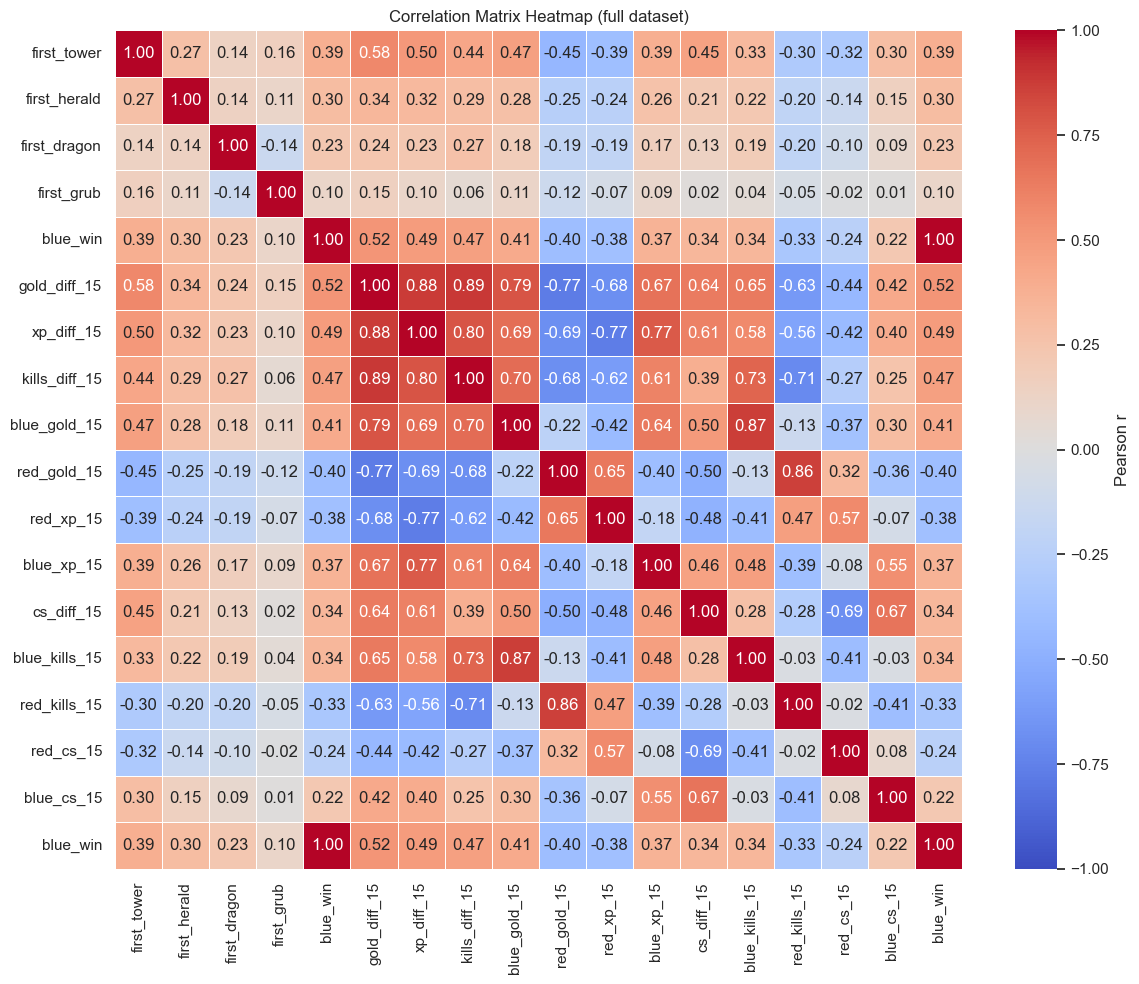

In [107]:
# Correlation matrix heatmap for numeric features
tmp = eda_df.copy()

# Normalize objective column names and cast bools to ints
alias_map = {
    'first_turret': 'first_tower',
    'first_drake': 'first_dragon',
}
for src, dst in alias_map.items():
    if src in tmp.columns and dst not in tmp.columns:
        tmp[dst] = tmp[src]
bool_cols = tmp.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    tmp[bool_cols] = tmp[bool_cols].astype(int)

# Convert first-objective columns with team strings into binary indicators
obj_cols = [c for c in tmp.columns if c.startswith('first_')]
for col in obj_cols:
    if tmp[col].dtype == object:
        tmp[col] = tmp[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)

num_cols = tmp.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = {'gameDuration', 'game_duration', 'queueId', 'queue_id'}
num_cols = [c for c in num_cols if c not in exclude_cols]

corr_with_label = tmp[num_cols].corrwith(tmp['blue_win']).fillna(0)

# Keep first objectives visible and retain strongest remaining signals
first_objectives = [c for c in tmp.columns if c.startswith('first_')]
first_objectives = sorted(first_objectives, key=lambda c: abs(corr_with_label.get(c, 0)), reverse=True)

ordered = []
for c in first_objectives:
    if c in num_cols and c not in ordered:
        ordered.append(c)
for c in corr_with_label.abs().sort_values(ascending=False).index:
    if c not in ordered:
        ordered.append(c)

take = ordered[:max(25, len(first_objectives))]
selected_cols = [c for c in take if c in num_cols]
selected_cols.append('blue_win')

corr_matrix = tmp[selected_cols].corr().fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'label': 'Pearson r'}
)
plt.title('Correlation Matrix Heatmap (full dataset)')
plt.tight_layout()
plt.show()

I use a correlation matrix to find out which features have the most correlation with the blue team winning the game, so I can extract the top features.

### What I see in this data:
- Early resource gaps (gold/xp/cs/kills diffs) align the most with `blue_win`, which means early leads correlate with winning.
- Blue absolute stats are warm (positive to win) while red counterparts are cool (negative to blue win), which is good because this mirror effect is expected.
- First‑objective flags (`first_tower/dragon/herald/grub`) appear mid‑strength; that can happen if objectives are largely a consequence of having a lead rather than an independent driver.

### What I will do next:
-   I will check for correlation between resource gaps (gold/xp/cs/kills diffs) so that if they correlate too much I don't need all of them, only the most important
-   I’ll dig deeper below by conditioning on lead size to see their incremental value.

## Correlation table

In [108]:
# Correlations of numeric features (full dataset)
tmp = eda_df.copy()

# Normalize objective column names and cast bools to ints
alias_map = {
    'first_turret': 'first_tower',
    'first_drake': 'first_dragon',
}
for src, dst in alias_map.items():
    if src in tmp.columns and dst not in tmp.columns:
        tmp[dst] = tmp[src]
bool_cols = tmp.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    tmp[bool_cols] = tmp[bool_cols].astype(int)

# Convert first-objective columns with team strings into binary indicators
obj_cols = [c for c in tmp.columns if c.startswith('first_')]
for col in obj_cols:
    if tmp[col].dtype == object:
        tmp[col] = tmp[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)

num_cols = tmp.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = {'blue_win', 'gameDuration', 'game_duration', 'queueId', 'queue_id'}
num_cols = [c for c in num_cols if c not in exclude_cols]

corr_raw = tmp[num_cols].corrwith(tmp['blue_win'])
corr = corr_raw.fillna(0).sort_values(key=np.abs, ascending=False)
print('Correlations with blue_win (Pearson r, -1 to 1; higher |r| = stronger linear relationship):')

# Compute orientation-agnostic ROC-AUC for each feature
y = tmp['blue_win'].astype(int)
auc_scores = {}
for col in num_cols:
    series = tmp[col].replace([np.inf, -np.inf], np.nan)
    mask = series.notna() & y.notna()
    if series[mask].nunique() < 2:
        continue
    try:
        auc = roc_auc_score(y[mask], series[mask])
        auc_scores[col] = max(auc, 1 - auc)
    except ValueError:
        continue

# Ensure all first objectives appear explicitly
first_objectives = [c for c in tmp.columns if c.startswith('first_')]
first_objectives = sorted(first_objectives, key=lambda c: abs(corr.get(c, 0)), reverse=True)

ordered = []
for c in first_objectives:
    if c not in ordered and c in corr.index.union(first_objectives):
        ordered.append(c)
for c in corr.index:
    if c not in ordered:
        ordered.append(c)

take = ordered[:max(25, len(first_objectives))]
rows = []
for col in take:
    if col in corr.index:
        rows.append({
            'feature': col,
            'Pearson r': corr[col],
            'ROC-AUC': auc_scores.get(col, np.nan)
        })
corr_df = (
    pd.DataFrame(rows)
    .set_index('feature')
    .sort_values('Pearson r', key=np.abs, ascending=False)
    .round(3)
 )
display(corr_df)

Correlations with blue_win (Pearson r, -1 to 1; higher |r| = stronger linear relationship):


,Pearson r,ROC-AUC
feature,,
gold_diff_15,0.517,0.805
xp_diff_15,0.487,0.785
kills_diff_15,0.467,0.772
blue_gold_15,0.406,0.735
red_gold_15,-0.402,0.733
first_tower,0.387,0.694
red_xp_15,-0.383,0.722
blue_xp_15,0.366,0.711
cs_diff_15,0.340,0.694


This table ranks features by linear association with `blue_win` and adds a single‑feature ROC‑AUC to show separability.

### What I see:
- `gold_diff_15`, `xp_diff_15`, `kills_diff_15`, `cs_diff_15` sit near the top - strong one‑dimensional signals, confirms what could be seen in the correlation matrix.
- Objective flags rank lower in r, but their AUCs show independent signal remains; combined with tempo metrics they can still help non‑linear models.
- Lower r for objectives likely reflects confounding: the team ahead tends to secure firsts.

### Why include this:
- `Pearson r` gives a clear ranking, and single‑feature `ROC‑AUC` shows how well each feature alone separates wins from losses.

### What I will do next:
- Inside equal `gold_diff_15` groups, I will check if first objectives (`first_turret`,`first_dragon`,etc.) still add value beyond the lead (reduces confounding).


## Top correlations bar chart

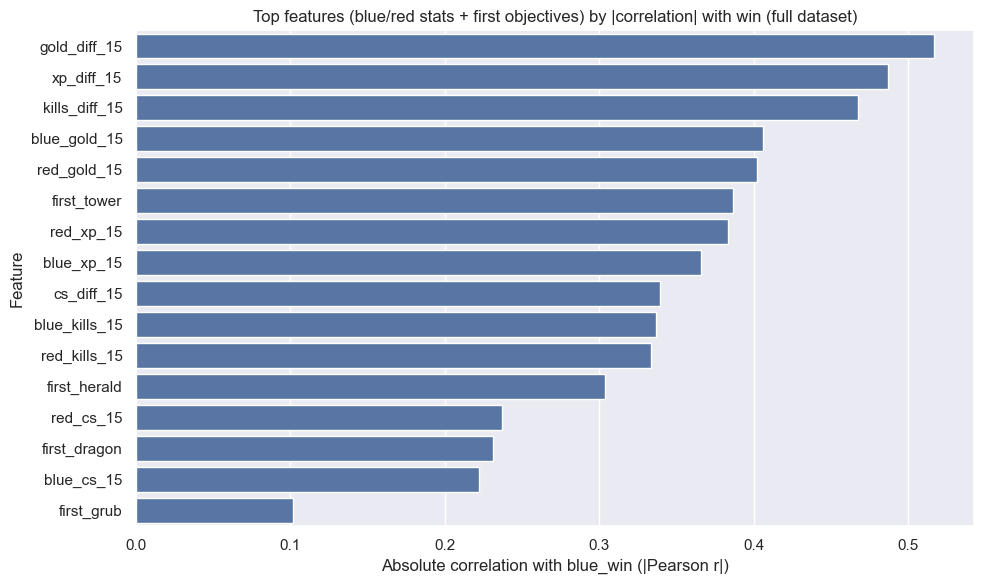

In [109]:
# Bar chart: top absolute correlations with blue_win (full dataset), ensuring first objectives and both sides included
if 'corr' in globals() and len(corr) > 0:
    objective_cols = [c for c in corr.index if c.startswith('first_')]
    objective_cols = sorted(objective_cols, key=lambda c: abs(corr[c]), reverse=True)
    ordered = []
    for c in objective_cols:
        if c not in ordered:
            ordered.append(c)
    for c in corr.abs().sort_values(ascending=False).index:
        if c not in ordered:
            ordered.append(c)
    chosen = ordered[:20]
    topN = corr.loc[chosen].abs().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topN.values, y=topN.index, orient='h')  # palette removed to avoid deprecation warning
    plt.xlabel('Absolute correlation with blue_win (|Pearson r|)')
    plt.ylabel('Feature')
    plt.title('Top features (blue/red stats + first objectives) by |correlation| with win (full dataset)')
    plt.tight_layout()
    plt.show()
else:
    print('Skipping bar chart: correlations not available.')

#### Why show three different visuals for “importance”?
I use all three together to see both structure and ranking:
- **Correlation matrix:** shows clusters and mirrored blue/red relations; great for spotting redundancy and families of features.
- **Correlation table:** sorts by absolute Pearson r and adds ROC‑AUC per feature; this gives an at‑a‑glance ranking and complements the matrix.
- **Top correlations bar chart:** the simplest visual for "which features are strongest," especially when presenting or deciding quick baselines, this gives the best "at a glance" visualization.
Together they help me first understand the landscape (matrix), then quantify and rank (table), and finally communicate the winners clearly (bar chart). I keep all three because the heatmap alone is hard to read for exact ranks, and the bars alone hide relationships between features.

### Deeper look: objectives vs early lead
One‑liner: lower raw correlations for objectives can hide incremental value once we control for lead size.

I bin `gold_diff_15` into deciles and compare win rates for teams that got the objective first vs those that didn’t within the same lead group. This shows whether “first dragon/tower” still adds lift beyond simply being ahead.

C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\1725012100.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = (tmp.groupby(['lead_bin', col])['blue_win']
C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\1725012100.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = (tmp.groupby(['lead_bin', col])['blue_win']
C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\1725012100.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

,feature,lead_bin,lift
0,first_dragon,"(-12349.001, -4119.0]",0.048621
1,first_dragon,"(-4119.0, -2613.0]",0.141753
2,first_dragon,"(-2613.0, -1558.0]",0.121938
3,first_dragon,"(-1558.0, -689.6]",0.106164
4,first_dragon,"(-689.6, 125.0]",0.104520
5,first_dragon,"(125.0, 911.0]",0.193830
6,first_dragon,"(911.0, 1787.0]",0.139034
7,first_dragon,"(1787.0, 2827.0]",0.083884
8,first_dragon,"(2827.0, 4308.4]",0.096963
9,first_dragon,"(4308.4, 13578.0]",0.098764


C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\1725012100.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = (tmp.groupby(['lead_bin', col])['blue_win']
C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\1725012100.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = (tmp.groupby(['lead_bin', col])['blue_win']
C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\1725012100.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

,feature,lead_bin,lift
0,first_dragon,"(-12349.001, -4119.0]",0.048621
1,first_dragon,"(-4119.0, -2613.0]",0.141753
2,first_dragon,"(-2613.0, -1558.0]",0.121938
3,first_dragon,"(-1558.0, -689.6]",0.106164
4,first_dragon,"(-689.6, 125.0]",0.104520
5,first_dragon,"(125.0, 911.0]",0.193830
6,first_dragon,"(911.0, 1787.0]",0.139034
7,first_dragon,"(1787.0, 2827.0]",0.083884
8,first_dragon,"(2827.0, 4308.4]",0.096963
9,first_dragon,"(4308.4, 13578.0]",0.098764


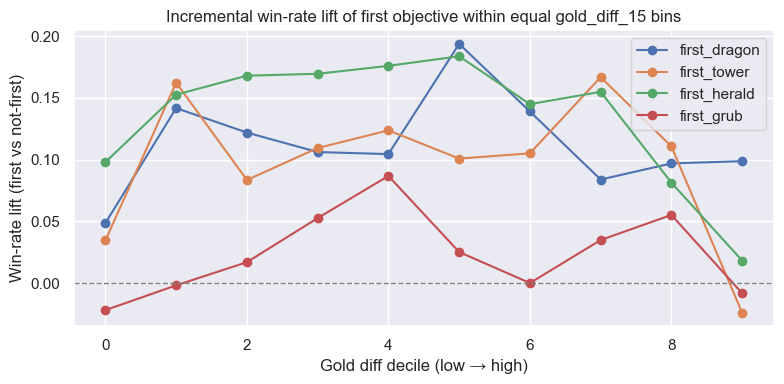

In [110]:
tmp = eda_df.copy()
if 'gold_diff_15' not in tmp.columns:
    print('Skip: gold_diff_15 not available.')
else:
    # Normalize objective flags to numeric 0/1
    alias_map = {'first_turret': 'first_tower','first_drake': 'first_dragon'}
    for src, dst in alias_map.items():
        if src in tmp.columns and dst not in tmp.columns:
            tmp[dst] = tmp[src]
    for col in [c for c in tmp.columns if c.startswith('first_')]:
        if tmp[col].dtype == object:
            tmp[col] = tmp[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)
    # Bin by early lead
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna(subset=['gold_diff_15','blue_win'])
    tmp['lead_bin'] = pd.qcut(tmp['gold_diff_15'], 10, duplicates='drop')
    check_cols = [c for c in ['first_dragon','first_tower','first_herald', 'first_grub'] if c in tmp.columns]
    results = []
    for col in check_cols:
        grp = (tmp.groupby(['lead_bin', col])['blue_win']
                 .agg(win_rate='mean', n='size')
                 .reset_index())
        # Compute within-bin lift: win_rate(first=1) - win_rate(first=0)
        pivot = grp.pivot(index='lead_bin', columns=col, values='win_rate')
        pivot['lift'] = pivot.get(1.0, np.nan) - pivot.get(0.0, np.nan)
        pivot['feature'] = col
        results.append(pivot.reset_index())
    if results:
        out = pd.concat(results, ignore_index=True)
        display(out[['feature','lead_bin','lift']].dropna().sort_values(['feature','lead_bin']))
        plt.figure(figsize=(8,4))
        for col in check_cols:
            sub = out[out['feature']==col]
            plt.plot(range(len(sub)), sub['lift'].values, marker='o', label=col)
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.title('Incremental win-rate lift of first objective within equal gold_diff_15 bins')
        plt.ylabel('Win-rate lift (first vs not-first)')
        plt.xlabel('Gold diff decile (low → high)')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print('No objective columns to analyze.')

### What I can see:

Where leads are small, some objectives (often `first_tower`, `first_dragon` and `first_herald`) still show positive lift; where leads are huge, lift shrinks because the game is already decided. This suggests keeping objective flags - they add situational signal beyond raw gold when the game is close.

Each curve overlays the distribution of a feature for wins vs losses. Short take: wider separation = more discriminative power; heavy overlap = weaker on its own.

For this project:
- gold_diff_15 and xp_diff_15 curves for wins shift to the right with less overlap, confirming early leads matter.
- Some features show long tails/outliers (e.g., very large gold leads or deficits). These likely come from early stomps or comeback games; we’ll analyze outliers below to decide whether to keep or cap them for linear/KNN baselines.

# Boxplots: top features by outcome (full dataset)


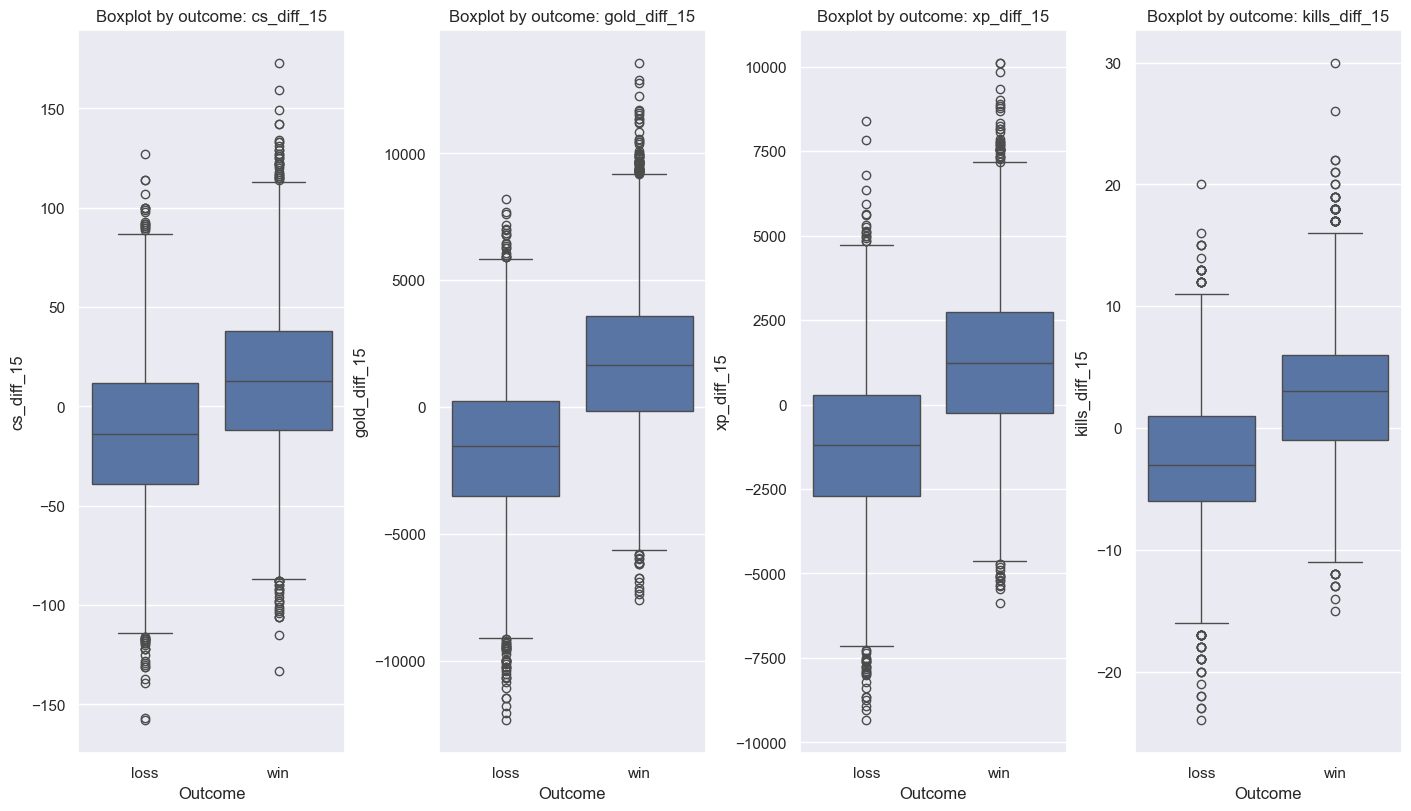

In [111]:
if 'corr' in globals() and len(corr) > 0:
    # Ensure cs_diff_15 is shown, plus other top features
    candidates = list(corr.index)
    features = []
    if 'cs_diff_15' in eda_df.columns:
        features.append('cs_diff_15')
    for f in candidates:
        if f not in features and f != 'blue_win' and (pd.api.types.is_float_dtype(eda_df[f]) or eda_df[f].nunique() > 10):
            features.append(f)
        if len(features) >= 4:
            break
    if features:
        bx = eda_df[['blue_win'] + features].copy().replace([np.inf, -np.inf], np.nan).dropna()
        bx['blue_win'] = bx['blue_win'].map({0: 'loss', 1: 'win'})
        n = len(features)
        fig, axes = plt.subplots(1, n, figsize=(3*n+2, 8), constrained_layout=True)
        if n == 1:
            axes = [axes]
        for ax, f in zip(axes, features):
            sns.boxplot(data=bx, x='blue_win', y=f, ax=ax)
            ax.set_title(f'Boxplot by outcome: {f}')
            ax.set_xlabel('Outcome')
            ax.set_ylabel(f)
        plt.show()
    else:
        print('No features available for boxplots.')
else:
    print('Skipping boxplots: correlations not available.')

These boxplots compare the distribution of top features for wins vs losses. I look for median shifts (line inside the box), spread (box size), and outliers.

My takeaways:
- Winning games tend to have higher medians for early‑advantage features (e.g., `gold_diff_15`, `xp_diff_15`). The boxes are also narrower, hinting at more consistent leads when teams win.
- Losses have lower (or negative) medians and often wider spreads, meaning that being behind comes in many forms.
- Outliers remind me there are exceptions: some teams win from behind or lose despite a lead. That’s one reason I evaluate with multiple metrics, not just accuracy.

## Outlier analysis (top continuous features)

I check outliers for `gold_diff_15`, `xp_diff_15`, `cs_diff_15`, `kills_diff_15` and preview a few matches to see if they are early stomps or unusual comebacks.

In [112]:
conts = [c for c in ['gold_diff_15','xp_diff_15','cs_diff_15','kills_diff_15'] if c in eda_df.columns]
if not conts:
    print('No continuous top features available for outlier check.')
else:
    outlier_summary = []
    view_cols = ['matchId','blue_win','first_tower','first_dragon','first_herald','first_grub']
    view_cols = [c for c in view_cols if c in eda_df.columns] + conts
    sample_rows = []
    for col in conts:
        s = eda_df[col].replace([np.inf,-np.inf], np.nan).dropna()
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        mask_hi = eda_df[col] > high
        mask_lo = eda_df[col] < low
        n_hi, n_lo = int(mask_hi.sum()), int(mask_lo.sum())
        outlier_summary.append({'feature': col, 'low_thresh': float(low), 'high_thresh': float(high), 'n_low': n_lo, 'n_high': n_hi})
        # collect a few examples
        ex_hi = eda_df[mask_hi].head(3)[view_cols] if n_hi>0 else pd.DataFrame()
        ex_lo = eda_df[mask_lo].head(3)[view_cols] if n_lo>0 else pd.DataFrame()
        if len(ex_hi):
            ex_hi['which'] = f'{col}_high'
            sample_rows.append(ex_hi)
        if len(ex_lo):
            ex_lo['which'] = f'{col}_low'
            sample_rows.append(ex_lo)
    display(pd.DataFrame(outlier_summary))
    if sample_rows:
        display(pd.concat(sample_rows, ignore_index=True))
    else:
        print('No extreme outliers found by IQR rule.')

,feature,low_thresh,high_thresh,n_low,n_high
0,gold_diff_15,-8547.0,8741.0,59,80
1,xp_diff_15,-6876.5,6967.5,37,41
2,cs_diff_15,-108.0,108.0,35,48
3,kills_diff_15,-16.0,16.0,31,49


,matchId,blue_win,first_tower,first_dragon,first_herald,first_grub,gold_diff_15,xp_diff_15,cs_diff_15,kills_diff_15,which
0,EUN1_3504041008,1,blue,blue,red,None,9483,6522,39,21,gold_diff_15_high
1,EUN1_3512684594,1,blue,blue,blue,None,11216,6538,123,9,gold_diff_15_high
2,EUN1_3552100615,1,blue,red,None,blue,9712,7373,65,18,gold_diff_15_high
3,EUN1_3497273273,0,red,red,red,None,-8821,-5515,-60,-11,gold_diff_15_low
4,EUN1_3499042211,0,red,blue,red,None,-9747,-4982,-102,-12,gold_diff_15_low
5,EUN1_3549678579,0,red,red,None,blue,-10312,-6990,-107,-19,gold_diff_15_low
6,EUN1_3552100615,1,blue,red,None,blue,9712,7373,65,18,xp_diff_15_high
7,EUN1_3597730684,1,blue,blue,blue,blue,11694,8077,42,18,xp_diff_15_high
8,EUN1_3604113199,1,blue,blue,blue,red,8502,7172,110,11,xp_diff_15_high
9,EUN1_3549678579,0,red,red,None,blue,-10312,-6990,-107,-19,xp_diff_15_low


- Likely causes: early stomps (huge positive leads) and rare comebacks (large negatives that still win).
- Modeling impact: tree‑based models tolerate them; linear/KNN can be sensitive. If needed, we can winsorize caps (e.g., at 1st/99th pct) only for linear/KNN baselines and leave trees untouched.

### Feature redundancy pruning (keep the most informative, drop near-duplicates)

I detect highly similar metrics (e.g., `gold_diff_15` vs `xp_diff_15`) using a correlation threshold and keep only one representative from each cluster.
- Score each feature by its absolute correlation with `blue_win`.
- Traverse from strongest to weakest; keep a feature only if its correlation with all kept features is below a threshold (default 0.85).
- Always allow `first_` objective flags to pass through first, then fill with the strongest remaining signals.

This makes visualizations clearer and reduces redundant inputs for linear models. Trees are robust to some redundancy, but pruning still helps interpretation.

Kept 12 features (threshold=0.85). Example kept head: ['first_tower', 'first_herald', 'first_dragon', 'first_grub', 'gold_diff_15', 'blue_gold_15', 'red_gold_15', 'red_xp_15', 'blue_xp_15', 'cs_diff_15']


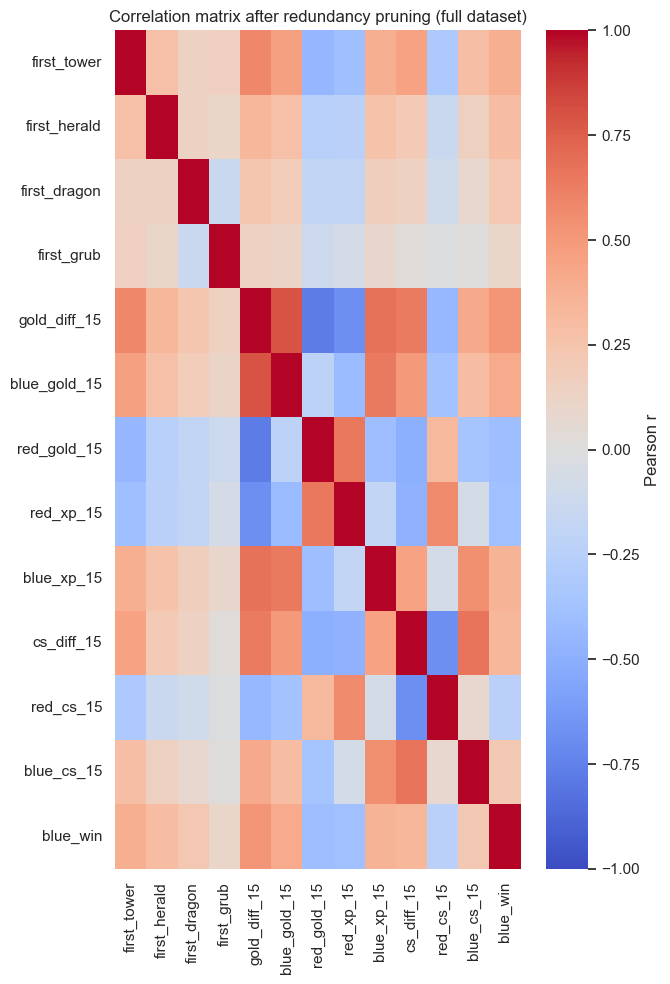

,dropped_feature,representative,corr
1,kills_diff_15,gold_diff_15,0.887172
0,xp_diff_15,gold_diff_15,0.881048
2,blue_kills_15,blue_gold_15,0.868788
3,red_kills_15,red_gold_15,0.863840


In [113]:
# Greedy pruning of highly correlated features (full dataset)
df = eda_df.copy()
# Normalize objectives and cast bools
alias_map = {'first_turret': 'first_tower','first_drake': 'first_dragon'}
for src, dst in alias_map.items():
    if src in df.columns and dst not in df.columns:
        df[dst] = df[src]
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    df[bool_cols] = df[bool_cols].astype(int)
obj_cols = [c for c in df.columns if c.startswith('first_')]
for col in obj_cols:
    if df[col].dtype == object:
        df[col] = df[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude = {'blue_win', 'gameDuration', 'game_duration', 'queueId', 'queue_id'}
num_cols = [c for c in num_cols if c not in exclude]

corr_series = df[num_cols].corrwith(df['blue_win']).fillna(0)
# Candidate ranking: objectives first (by |r|), then others by |r|
objectives_sorted = [c for c in obj_cols if c in corr_series.index]
objectives_sorted = sorted(objectives_sorted, key=lambda c: abs(corr_series[c]), reverse=True)
others_sorted = [c for c in corr_series.abs().sort_values(ascending=False).index if c not in objectives_sorted]
ordered = objectives_sorted + others_sorted

# Greedy keep under pairwise threshold
threshold = 0.85
chosen = []
dropped = []
for f in ordered:
    keep = True
    for g in chosen:
        r = df[[f, g]].corr().iloc[0,1]
        if pd.notna(r) and abs(r) >= threshold:
            dropped.append((f, g, r))
            keep = False
            break
    if keep:
        chosen.append(f)

print(f"Kept {len(chosen)} features (threshold={threshold}). Example kept head:", chosen[:10])
pruned_matrix = df[chosen + ['blue_win']].corr().fillna(0)
plt.figure(figsize=(min(14, 2 + 0.4*len(chosen)), 10))
sns.heatmap(pruned_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=False, cbar_kws={'label': 'Pearson r'})
plt.title('Correlation matrix after redundancy pruning (full dataset)')
plt.tight_layout()
plt.show()

# Show a small table of dropped features and their nearest kept representative
if dropped:
    dropped_df = pd.DataFrame(dropped, columns=['dropped_feature','representative','corr']).sort_values('corr', key=np.abs, ascending=False)
    display(dropped_df.head(15))
else:
    print('No features dropped by redundancy threshold.')

#### What changed after pruning and why it matters
- Highly similar metrics (|r| ≥ 0.85) are treated as redundant. For example, `xp_diff_15` and `kills_diff_15` can be near-duplicates of `gold_diff_15` in this dataset, so I keep `gold_diff_15` as the representative and drop the others for clearer visuals and simpler linear baselines.
- The table above lists which features were dropped and which representative they were closest to. This is not a causal statement — it’s a pragmatic way to avoid double‑counting the same signal.
- I keep all `first_` objective flags regardless; they capture discrete game events complementary to resource gaps.
- Downstream: I can try linear models twice — once with full features, and once with the pruned set — to show whether pruning helps calibration or reduces variance.

### Note on blue/red features in correlation views
- I keep both blue_ and red_ stats so we can see how each team’s raw values relate to `blue_win`. Blue features usually correlate positively (higher value → higher blue win odds), while red features often show negative correlations (higher value -> lower blue win odds).
- First-objective flags (`first_tower`, `first_dragon`, `first_herald`, `first_blood`, `first_grub`, etc.) are always surfaced alongside the resource stats so objective control remains visible in the heatmap/table.
- Diff-style metrics (`_diff_15`) summarize the state gap; seeing them next to individual blue/red stats helps decide whether absolute values or differentials drive outcomes.
- Long-duration or lobby descriptors (`gameDuration`, `queueId`) are excluded to keep the focus on early-game state rather than post-outcome or matchmaking artefacts.
- EDA uses the full dataset here; leakage is only a concern when training models, which we handle via proper train/test evaluation.
- Because many of the top features belong to the same “early lead” cluster, including all of them in linear models may be redundant; for trees it’s less harmful but still not always necessary.

## Win rate by early objectives

### Feature correlations - what this tells us
Short read: early economy features correlate strongly with outcome; objective flags are relevant but more modest on raw r.

In our data:
- Gold/XP/CS/Kills diffs show the strongest linear links to `blue_win`.
- Objective control (first tower/dragon/herald) has moderate correlation, confirming relevance.
- Blue vs red mirror patterns validate that features are well-behaved and interpretable.

Win rate by first_tower (full dataset):



Win rate by first_tower (full dataset):



,win_rate,n
first_tower,,
blue,0.706449,5086
red,0.319478,4908


Win rate by first_tower (full dataset):



,win_rate,n
first_tower,,
blue,0.706449,5086
red,0.319478,4908


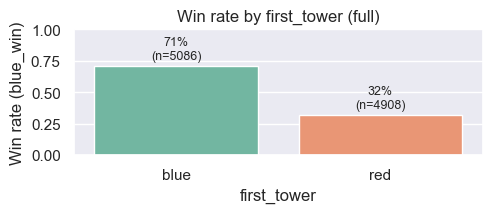

Win rate by first_dragon (full dataset):



Win rate by first_tower (full dataset):



,win_rate,n
first_tower,,
blue,0.706449,5086
red,0.319478,4908


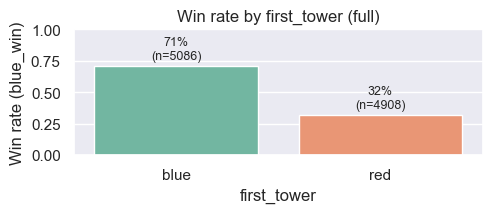

Win rate by first_dragon (full dataset):



,win_rate,n
first_dragon,,
blue,0.636685,4803
red,0.405239,5192


Win rate by first_tower (full dataset):



,win_rate,n
first_tower,,
blue,0.706449,5086
red,0.319478,4908


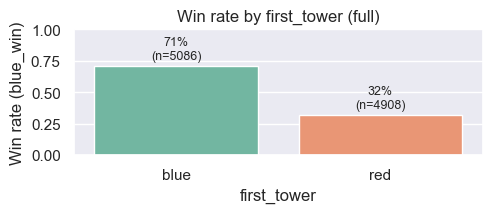

Win rate by first_dragon (full dataset):



,win_rate,n
first_dragon,,
blue,0.636685,4803
red,0.405239,5192


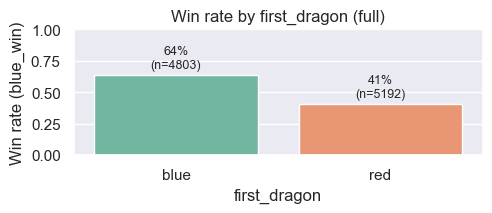

Win rate by first_herald (full dataset):



,win_rate,n
first_herald,,
blue,0.674511,4802
red,0.338412,4332


Win rate by first_tower (full dataset):



,win_rate,n
first_tower,,
blue,0.706449,5086
red,0.319478,4908


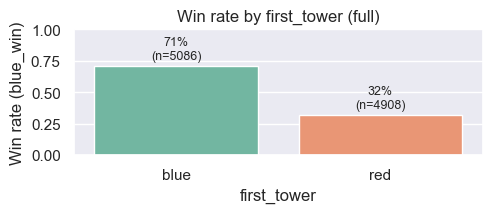

Win rate by first_dragon (full dataset):



,win_rate,n
first_dragon,,
blue,0.636685,4803
red,0.405239,5192


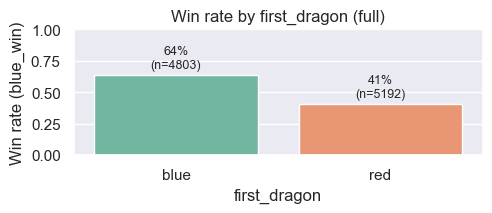

Win rate by first_herald (full dataset):



,win_rate,n
first_herald,,
blue,0.674511,4802
red,0.338412,4332


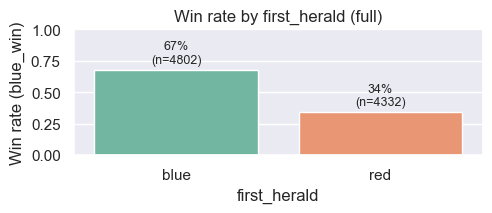

Win rate by first_grub (full dataset):



,win_rate,n
first_grub,,
blue,0.566965,5025
red,0.465822,4813


Win rate by first_tower (full dataset):



,win_rate,n
first_tower,,
blue,0.706449,5086
red,0.319478,4908


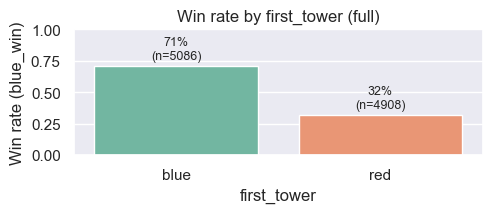

Win rate by first_dragon (full dataset):



,win_rate,n
first_dragon,,
blue,0.636685,4803
red,0.405239,5192


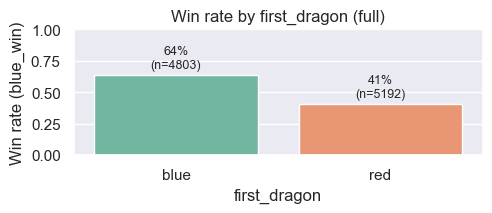

Win rate by first_herald (full dataset):



,win_rate,n
first_herald,,
blue,0.674511,4802
red,0.338412,4332


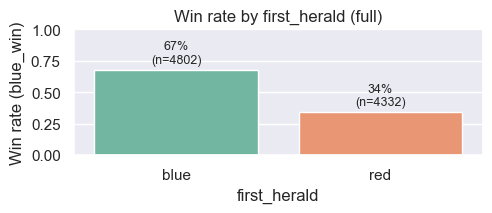

Win rate by first_grub (full dataset):



,win_rate,n
first_grub,,
blue,0.566965,5025
red,0.465822,4813


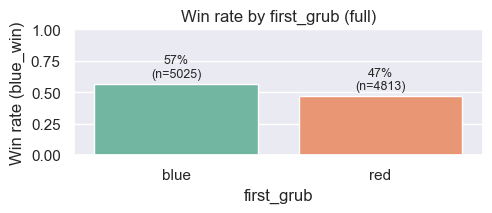

In [114]:
# Win-rate by early objective control (full dataset)
possible_cols = ['first_tower', 'first_turret', 'first_dragon', 'first_herald', 'first_blood', 'first_grub']
objective_cols = [col for col in possible_cols if col in eda_df.columns]

for col in objective_cols:
    print(f"Win rate by {col} (full dataset):\n")
    grp = (
        eda_df.groupby(col)
        .agg(win_rate=('blue_win', 'mean'), n=('blue_win', 'size'))
        .reset_index()
    )
    display(grp.set_index(col))

    plt.figure(figsize=(5, 2.3))
    ax = sns.barplot(data=grp, x=col, y='win_rate', hue=col, palette='Set2', legend=False)
    ax.set_ylim(0, 1)
    ax.set_title(f"Win rate by {col} (full)")
    ax.set_ylabel("Win rate (blue_win)")

    for p, (_, row) in zip(ax.patches, grp.iterrows()):
        ax.annotate(
            f"{row['win_rate']:.0%}\n(n={int(row['n'])})",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center', va='bottom', fontsize=9, xytext=(0, 3), textcoords='offset points'
        )

    plt.tight_layout()
    plt.show()

This view summarizes how often the blue side wins when it secures early objectives first (tower, dragon, herald, etc.). Bars show win rates; the table below lists the exact percentages.

What I conclude:
- Taking the first tower and first dragon both associate with a noticeably higher win rate. These aren’t perfect predictors, but they meaningfully tilt the game.
- The uplift sizes differ: if one objective’s bar is much higher, I give it more weight in feature engineering or model interpretation.
- Caution: teams that are already ahead are more likely to take first objectives (confounding). The model can still learn useful patterns, but I don’t treat these as causal.

Practical use: I keep these as binary features (with care to avoid leakage) and let the model combine them with resource diffs.

## Modeling

### Evaluation

Now I train and evaluate models, focusing on predicted win probability (0–100%). The final selected model is Logistic Regression (pruned) for interpretability and stable calibration; I also compare Random Forest, KNN, Linear Regression (probability regressor), and XGBoost (binary logistic) to understand trade-offs.

What I test:

- Models: Logistic Regression (pruned, final), Random Forest, KNN, Linear Regression (prob regressor), XGBoost (binary:logistic)

- Metrics at a 0.5 threshold: Accuracy, Precision, Recall, F1

- Probability quality: ROC-AUC and Log Loss; I also report test Accuracy and Precision prominently in summaries

- Calibration: reliability curves to check if “70% predicted” ≈ 70% observed wins

- Deliverable: a calibrated probability for blue win on the test set

What I can tell from this:

- Logistic Regression (pruned) offers a simple, interpretable baseline with solid calibration; trees/boosting may rank slightly better (ROC-AUC) but aren’t strictly necessary here.

# Data overview (after cleaning)

We’ll use this cleaned, de-duplicated 15-minute dataset for modeling. Next we will:
- Split into train/test (stratified by blue_win) and build modeling matrices.
- Evaluate multiple models as probability estimators (ROC-AUC, PR-AUC, Brier, LogLoss) and check calibration.
- Compare FULL vs PRUNED feature subsets, then select the best variant for each model.
- Summarize results and interpret the probabilities (not just hard labels).

In [115]:
# Size, sample, and column groups
n_rows, n_cols = eda_df.shape
print(f"Cleaned dataset: {n_rows} matches, {n_cols} features (including label)")

# Show a small sample
display(eda_df.head(3))

# Describe column groups
groups = {
    'label'      : [c for c in eda_df.columns if c == 'blue_win'],
    'ids'        : [c for c in eda_df.columns if c.lower() in {'matchid','gameid','match_id'}],
    'economy'    : [c for c in eda_df.columns if any(k in c for k in ['gold_15','xp_15','cs_15','kills_15','diff_15'])],
    'objectives' : [c for c in eda_df.columns if c.startswith('first_')],
    'queue/dur'  : [c for c in eda_df.columns if c.lower() in {'queueid','gameDuration'.lower(), 'game_duration'}],
}
for name, cols in groups.items():
    print(f"- {name}: {len(cols)} -> {cols}")

print("\nSummary:")
print("These features summarize early-game state at 15 minutes (economy diffs, team totals) and binary objective flags (first tower/dragon/herald/grub). The target is blue_win (1=blue victory).")

Cleaned dataset: 9997 matches, 20 features (including label)


Cleaned dataset: 9997 matches, 20 features (including label)


,matchId,queueId,gameDuration,blue_win,first_tower,first_dragon,first_herald,first_grub,blue_gold_15,red_gold_15,blue_xp_15,red_xp_15,blue_cs_15,red_cs_15,blue_kills_15,red_kills_15,gold_diff_15,cs_diff_15,xp_diff_15,kills_diff_15
0,EUN1_3492146409,420,1887,0,red,red,blue,None,24479,22140,26840,27121,356,360,12,4,2339,-4,-281,8
1,EUN1_3492292477,420,1621,1,blue,red,blue,None,24778,23723,26732,25658,347,277,11,12,1055,70,1074,-1
2,EUN1_3493321490,420,1540,0,red,blue,blue,None,23922,24663,28770,29089,345,373,6,6,-741,-28,-319,0


- label: 1 -> ['blue_win']
- ids: 1 -> ['matchId']
- economy: 12 -> ['blue_gold_15', 'red_gold_15', 'blue_xp_15', 'red_xp_15', 'blue_cs_15', 'red_cs_15', 'blue_kills_15', 'red_kills_15', 'gold_diff_15', 'cs_diff_15', 'xp_diff_15', 'kills_diff_15']
- objectives: 4 -> ['first_tower', 'first_dragon', 'first_herald', 'first_grub']
- queue/dur: 2 -> ['queueId', 'gameDuration']

Summary:
These features summarize early-game state at 15 minutes (economy diffs, team totals) and binary objective flags (first tower/dragon/herald/grub). The target is blue_win (1=blue victory).


In [116]:
# Split data for modeling (done here, not in EDA)
from sklearn.model_selection import train_test_split

stratify_col = full_df['blue_win'] if 'blue_win' in full_df.columns else None
train_df, test_df = train_test_split(
    full_df, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_col
)
val_df = None  # keep simple for now

# Build model matrices
X_train, y_train = prepare_xy(train_df)
X_test, y_test = prepare_xy(test_df)
X_val, y_val = (prepare_xy(val_df) if val_df is not None else (None, None))
print('Train/Test shapes:', X_train.shape, X_test.shape)

Train/Test shapes: (7997, 14) (2000, 14)


In [117]:
# Helper to evaluate models as probability estimators
def evaluate_prob_model(model, X_tr, y_tr, X_te, y_te, kind: str, threshold: float = 0.5) -> Dict[str, Any]:
    fitted = model.fit(X_tr, y_tr)
    # Get probabilities
    if kind == 'classifier':
        if hasattr(fitted, 'predict_proba'):
            proba = fitted.predict_proba(X_te)[:, 1]
        elif hasattr(fitted, 'decision_function'):
            decision = fitted.decision_function(X_te)
            proba = 1 / (1 + np.exp(-decision))
        else:
            # fall back to predict and clip
            proba = fitted.predict(X_te)
    else:
        proba = fitted.predict(X_te)
    proba = np.clip(proba, 0.0, 1.0)
    # Threshold for comparability
    y_pred = (proba >= threshold).astype(int)
    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average='binary', zero_division=0)
    # Probability-centric metrics
    roc = roc_auc_score(y_te, proba) if len(np.unique(y_te)) == 2 else np.nan
    ap = average_precision_score(y_te, proba)
    brier = brier_score_loss(y_te, proba)
    ll = log_loss(y_te, np.c_[1-proba, proba])
    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
        'roc_auc': roc, 'avg_precision': ap, 'brier': brier, 'log_loss': ll,
        'threshold': threshold, 'fitted': fitted, 'proba': proba,
    }

In [118]:
# Define candidate models for evaluation
models = []

# Logistic Regression (scaled)
models.append((
    'Logistic Regression',
    Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('clf', LogisticRegression(solver='liblinear', C=1.0, penalty='l2', random_state=RANDOM_STATE, max_iter=1000))
    ]),
    'classifier'
))

# Random Forest
models.append((
    'Random Forest',
    RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    'classifier'
))

# KNN (scaled)
models.append((
    'KNN',
    Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('knn', KNeighborsClassifier(n_neighbors=15))
    ]),
    'classifier'
))

# Linear Regression as probability regressor (clip to [0,1] handled in evaluator)
models.append((
    'Linear Regression',
    Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('linreg', LinearRegression())
    ]),
    'regressor'
))

# Optional: XGBoost if available
try:
    from xgboost import XGBClassifier  # type: ignore
    models.append((
        'XGBoost',
        XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            n_estimators=300,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        'classifier'
    ))
except Exception as _:
    pass

print(f"Defined {len(models)} models: {[m[0] for m in models]}")

Defined 5 models: ['Logistic Regression', 'Random Forest', 'KNN', 'Linear Regression', 'XGBoost']


In [119]:
# Train, evaluate, and collect probability metrics
prob_results = []
fitted_models: Dict[str, Any] = {}
all_probas: Dict[str, np.ndarray] = {}

for name, model, kind in models:
    try:
        m = evaluate_prob_model(model, X_train, y_train, X_test, y_test, kind)
        fitted_models[name] = m.pop('fitted')
        all_probas[name] = m.pop('proba')
        prob_results.append({'model': name, **m})
        print(f"{name}: f1={m['f1']:.3f} | roc_auc={m['roc_auc']:.3f} | acc={m['accuracy']:.3f} | precision={m['precision']:.3f}")
    except Exception as exc:
        warnings.warn(f'{name} failed: {exc}')

prob_results_df = pd.DataFrame(prob_results).sort_values(by='roc_auc', ascending=False)
prob_results_df

Logistic Regression: f1=0.735 | roc_auc=0.805 | acc=0.724 | precision=0.729
Random Forest: f1=0.732 | roc_auc=0.818 | acc=0.720 | precision=0.722
KNN: f1=0.714 | roc_auc=0.796 | acc=0.701 | precision=0.705
Linear Regression: f1=0.736 | roc_auc=0.805 | acc=0.727 | precision=0.734
Random Forest: f1=0.732 | roc_auc=0.818 | acc=0.720 | precision=0.722
KNN: f1=0.714 | roc_auc=0.796 | acc=0.701 | precision=0.705
Linear Regression: f1=0.736 | roc_auc=0.805 | acc=0.727 | precision=0.734
XGBoost: f1=0.724 | roc_auc=0.811 | acc=0.712 | precision=0.716
XGBoost: f1=0.724 | roc_auc=0.811 | acc=0.712 | precision=0.716


Logistic Regression: f1=0.735 | roc_auc=0.805 | acc=0.724 | precision=0.729
Random Forest: f1=0.732 | roc_auc=0.818 | acc=0.720 | precision=0.722
KNN: f1=0.714 | roc_auc=0.796 | acc=0.701 | precision=0.705
Linear Regression: f1=0.736 | roc_auc=0.805 | acc=0.727 | precision=0.734
Random Forest: f1=0.732 | roc_auc=0.818 | acc=0.720 | precision=0.722
KNN: f1=0.714 | roc_auc=0.796 | acc=0.701 | precision=0.705
Linear Regression: f1=0.736 | roc_auc=0.805 | acc=0.727 | precision=0.734
XGBoost: f1=0.724 | roc_auc=0.811 | acc=0.712 | precision=0.716
XGBoost: f1=0.724 | roc_auc=0.811 | acc=0.712 | precision=0.716


,model,accuracy,precision,recall,f1,roc_auc,avg_precision,brier,log_loss,threshold
1,Random Forest,0.7195,0.722222,0.742498,0.732220,0.818214,0.834297,0.172134,0.506780,0.5
4,XGBoost,0.7115,0.715501,0.732817,0.724055,0.810635,0.828918,0.178783,0.524793,0.5
3,Linear Regression,0.7265,0.733654,0.738625,0.736131,0.805156,0.821433,0.181026,0.552155,0.5
0,Logistic Regression,0.7235,0.728571,0.740561,0.734518,0.805131,0.822214,0.180055,0.533109,0.5
2,KNN,0.7005,0.704717,0.723136,0.713808,0.796354,0.797004,0.183356,0.696106,0.5


<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

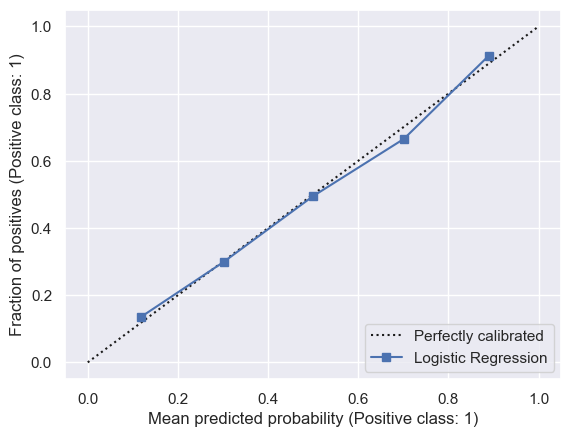

<Figure size 700x600 with 0 Axes>

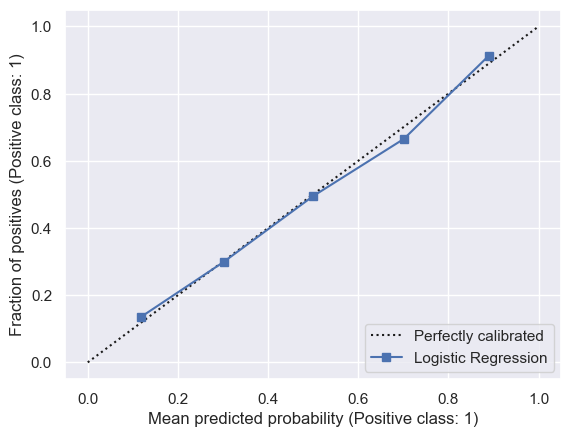

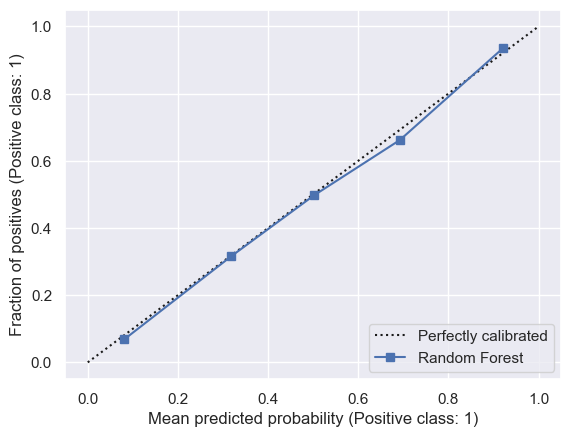

<Figure size 700x600 with 0 Axes>

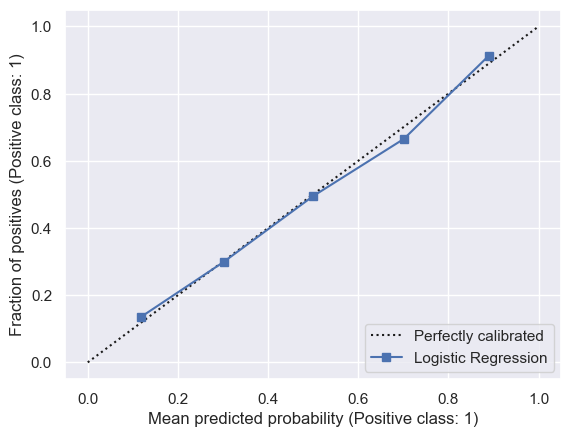

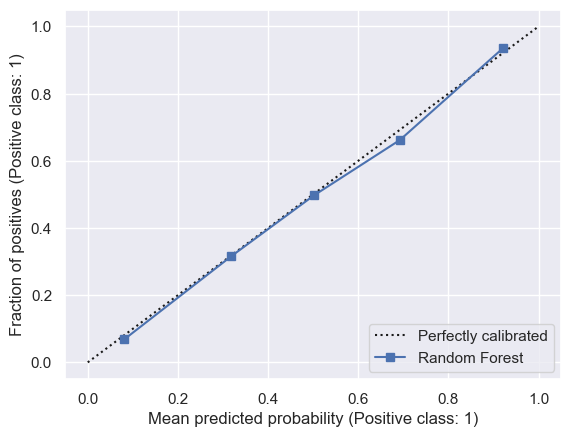

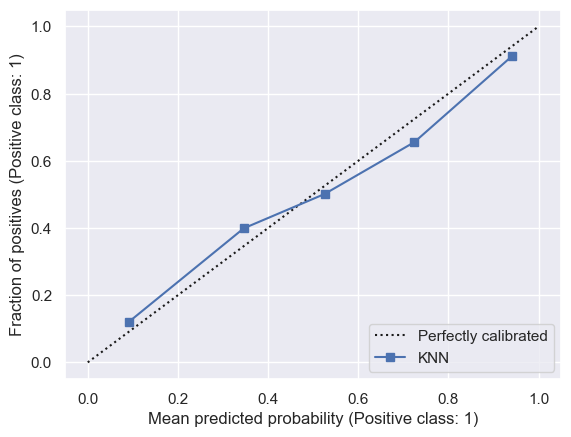

<Figure size 700x600 with 0 Axes>

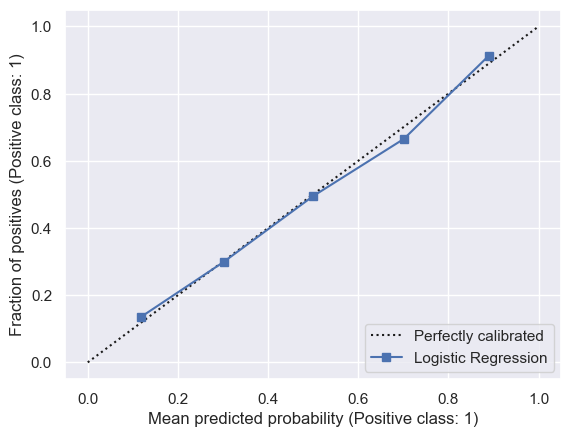

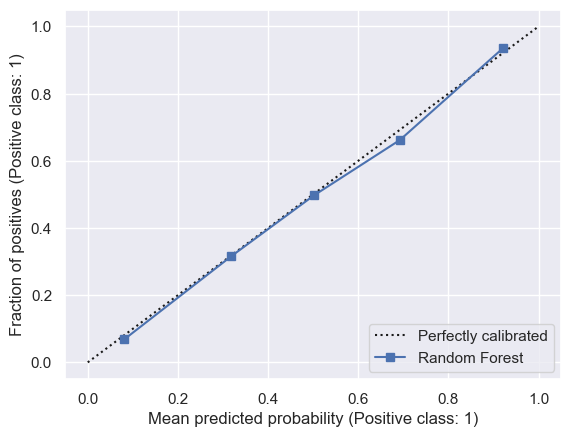

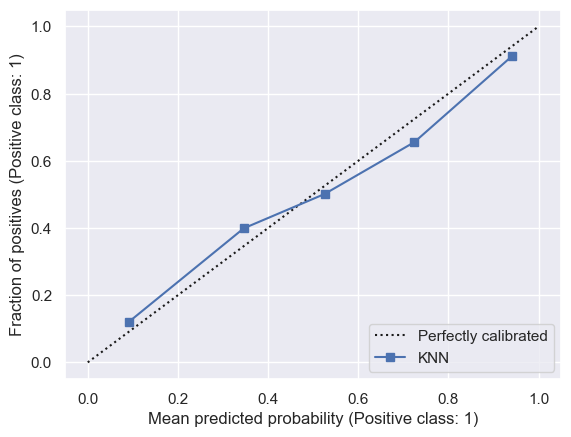

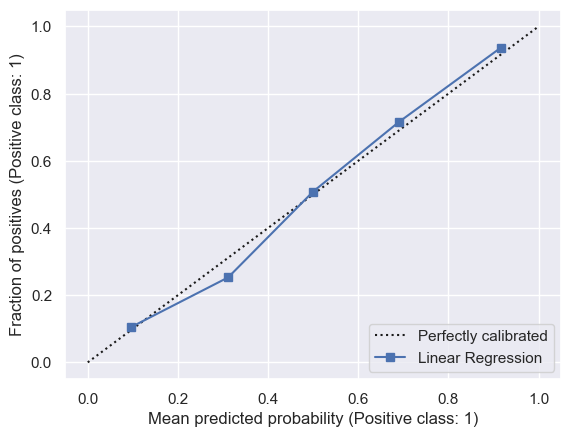

<Figure size 700x600 with 0 Axes>

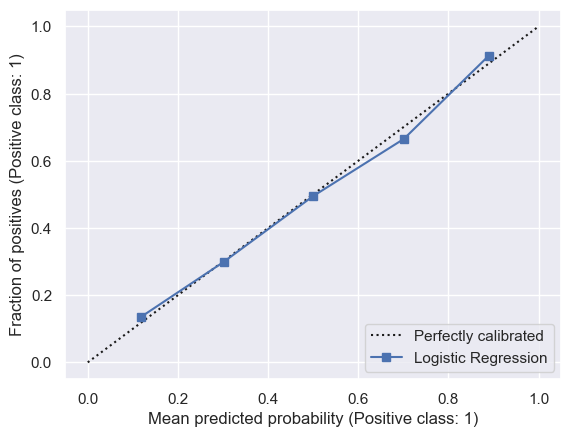

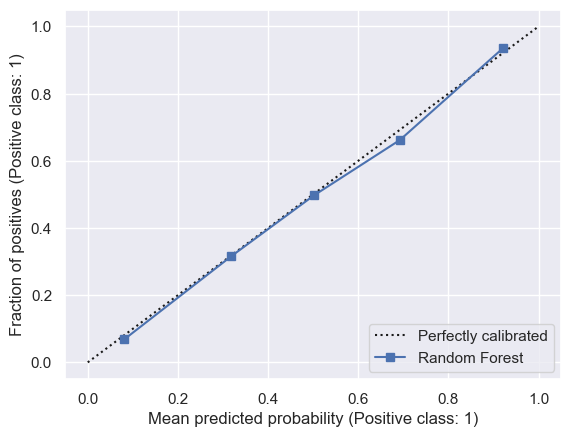

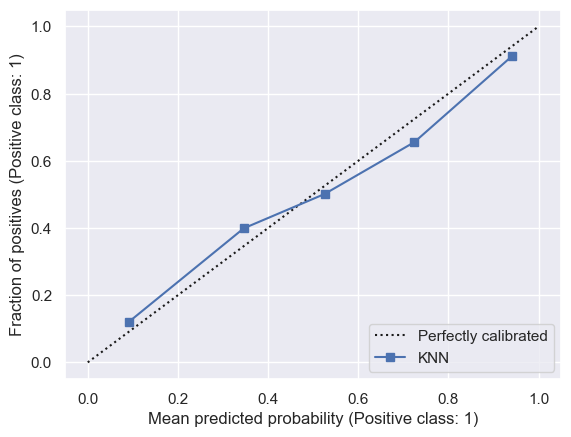

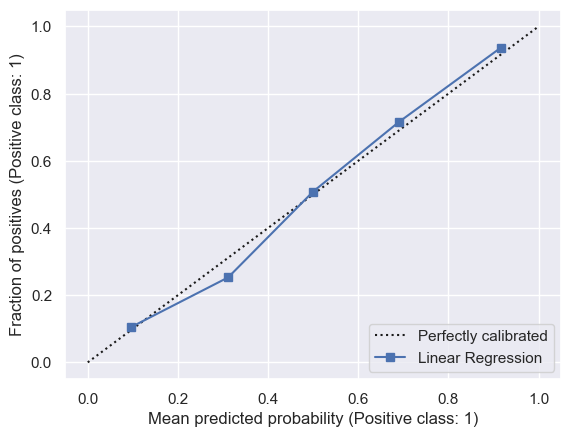

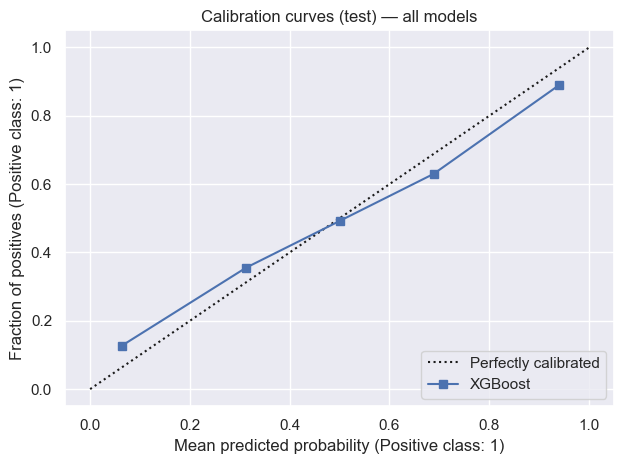

In [120]:
# Calibration (reliability) curves for all models
if 'all_probas' in globals() and len(all_probas) > 0:
    plt.figure(figsize=(7,6))
    for name, proba in all_probas.items():
        CalibrationDisplay.from_predictions(y_test, proba, name=name)
    plt.title('Calibration curves (test) — all models')
    plt.tight_layout()
    plt.show()
else:
    print('Skip calibration: no results yet.')

## Results and interpretation (as probabilities)
I report probability-focused metrics and show predicted win chances as percentages.
- ROC-AUC and Average Precision (PR-AUC) measure ranking quality of probabilities.
- Brier score and Log Loss penalize miscalibrated/confident errors; lower is better.
- I still report F1 at a 0.5 threshold for a simple operating point, but the main deliverable is a calibrated probability between 0% and 100%.

If calibration curves are close to the diagonal, the model’s predicted percentages match empirical frequencies; otherwise, I’d consider calibration (e.g., isotonic/Platt).

## Feature subset evaluation (train-only selection)
I investigate whether using only a small, hand-picked set of features improves performance. To avoid leakage, we select columns using the training/test split already created and only transform within the training data pathway.

For this pass we lock the feature subset to:
- `gold_diff_15`
- `cs_diff_15`
- `first_dragon`
- `first_tower`
- `first_herald`

I evaluate all models on FULL vs this PRUNED set and compare ROC-AUC, PR-AUC, Brier, Log Loss, plus a small ROC-AUC delta plot (pruned − full).

In [121]:
# Train-only feature selection — lock to a small, interpretable subset
from typing import Tuple

# Build modeling matrices with objective flags coerced to numeric when needed
OBJ_MAP = {'blue': 1, 'red': 0, 'none': 0}
ALIAS = {'first_turret': 'first_tower', 'first_drake': 'first_dragon'}
TARGET_FEATURES = ['gold_diff_15', 'cs_diff_15', 'first_dragon', 'first_tower', 'first_herald']

def prepare_xy_with_objectives(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    d = df.copy()
    # Apply aliases so we use consistent names
    for src, dst in ALIAS.items():
        if src in d.columns and dst not in d.columns:
            d[dst] = d[src]
    # Coerce objective flags to numeric 0/1 if they are objects/strings
    obj_cols = [c for c in d.columns if c.startswith('first_')]
    for col in obj_cols:
        if d[col].dtype == object:
            d[col] = d[col].astype(str).str.lower().map(OBJ_MAP).fillna(0).astype(int)
    # Reuse the earlier helper’s logic: numeric only, drop ids, clip label
    assert LABEL_COL in d.columns, f"Missing label column: {LABEL_COL}"
    y = d[LABEL_COL].astype(int).clip(0, 1)
    num_cols = d.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != LABEL_COL]
    drop_cols = [c for c in d.columns if c in ID_LIKE]
    X = d.drop(columns=drop_cols, errors='ignore')[num_cols].copy().fillna(0)
    return X, y

# Re-derive X/y with objective encoding for this subsection only
X_train_sub, y_train_sub = prepare_xy_with_objectives(train_df)
X_test_sub, y_test_sub = prepare_xy_with_objectives(test_df)

# Lock to requested subset (only keep those available)
available = set(X_train_sub.columns)
selected_features = [c for c in TARGET_FEATURES if c in available]
missing = [c for c in TARGET_FEATURES if c not in available]
if missing:
    print("Warning: missing requested features (not numeric or absent in data):", missing)
if not selected_features:
    raise RuntimeError("None of the requested features are available as numeric columns.")

print(f"Selected {len(selected_features)} fixed features:", selected_features)
X_train_sel = X_train_sub[selected_features]
X_test_sel  = X_test_sub[selected_features]

Selected 5 fixed features: ['gold_diff_15', 'cs_diff_15', 'first_dragon', 'first_tower', 'first_herald']


In [122]:
# Evaluate the same models on the pruned feature set
prob_results_pruned = []
fitted_models_pruned: Dict[str, Any] = {}
all_probas_pruned: Dict[str, np.ndarray] = {}

for name, model, kind in models:
    try:
        m = evaluate_prob_model(model, X_train_sel, y_train, X_test_sel, y_test, kind)
        fitted_models_pruned[name + " (pruned)"] = m.pop('fitted')
        all_probas_pruned[name + " (pruned)"] = m.pop('proba')
        prob_results_pruned.append({'model': name + " (pruned)", **m})
        print(f"{name} (pruned): f1={m['f1']:.3f} | roc_auc={m['roc_auc']:.3f} | ap={m['avg_precision']:.3f} | brier={m['brier']:.3f}")
    except Exception as exc:
        warnings.warn(f"{name} (pruned) failed: {exc}")

prob_results_pruned_df = (
    pd.DataFrame(prob_results_pruned)
      .sort_values(by=['roc_auc','avg_precision','brier','log_loss'], ascending=[False,False,True,True])
      .reset_index(drop=True)
)
prob_results_pruned_df

Logistic Regression (pruned): f1=0.754 | roc_auc=0.824 | ap=0.828 | brier=0.171
Random Forest (pruned): f1=0.717 | roc_auc=0.778 | ap=0.777 | brier=0.201
KNN (pruned): f1=0.739 | roc_auc=0.804 | ap=0.793 | brier=0.181
Linear Regression (pruned): f1=0.756 | roc_auc=0.824 | ap=0.826 | brier=0.172
XGBoost (pruned): f1=0.740 | roc_auc=0.808 | ap=0.812 | brier=0.179
Random Forest (pruned): f1=0.717 | roc_auc=0.778 | ap=0.777 | brier=0.201
KNN (pruned): f1=0.739 | roc_auc=0.804 | ap=0.793 | brier=0.181
Linear Regression (pruned): f1=0.756 | roc_auc=0.824 | ap=0.826 | brier=0.172
XGBoost (pruned): f1=0.740 | roc_auc=0.808 | ap=0.812 | brier=0.179


Logistic Regression (pruned): f1=0.754 | roc_auc=0.824 | ap=0.828 | brier=0.171
Random Forest (pruned): f1=0.717 | roc_auc=0.778 | ap=0.777 | brier=0.201
KNN (pruned): f1=0.739 | roc_auc=0.804 | ap=0.793 | brier=0.181
Linear Regression (pruned): f1=0.756 | roc_auc=0.824 | ap=0.826 | brier=0.172
XGBoost (pruned): f1=0.740 | roc_auc=0.808 | ap=0.812 | brier=0.179
Random Forest (pruned): f1=0.717 | roc_auc=0.778 | ap=0.777 | brier=0.201
KNN (pruned): f1=0.739 | roc_auc=0.804 | ap=0.793 | brier=0.181
Linear Regression (pruned): f1=0.756 | roc_auc=0.824 | ap=0.826 | brier=0.172
XGBoost (pruned): f1=0.740 | roc_auc=0.808 | ap=0.812 | brier=0.179


,model,accuracy,precision,recall,f1,roc_auc,avg_precision,brier,log_loss,threshold
0,Linear Regression (pruned),0.7430,0.742297,0.769603,0.755703,0.823966,0.825835,0.172310,0.580700,0.5
1,Logistic Regression (pruned),0.7420,0.743180,0.764763,0.753817,0.823948,0.828412,0.171088,0.513130,0.5
2,XGBoost (pruned),0.7285,0.732890,0.746370,0.739568,0.808115,0.812430,0.179287,0.535310,0.5
3,KNN (pruned),0.7280,0.731754,0.747338,0.739464,0.803809,0.792635,0.181096,0.699956,0.5
4,Random Forest (pruned),0.7060,0.712512,0.722168,0.717308,0.777535,0.776847,0.200656,0.690247,0.5


,model,roc_auc_full,roc_auc_pruned,delta_roc_auc
2,Logistic Regression,0.805131,0.823948,0.018817
1,Linear Regression,0.805156,0.823966,0.018810
0,KNN,0.796354,0.803809,0.007455
4,XGBoost,0.810635,0.808115,-0.002520
3,Random Forest,0.818214,0.777535,-0.040679


,model,roc_auc_full,roc_auc_pruned,delta_roc_auc
2,Logistic Regression,0.805131,0.823948,0.018817
1,Linear Regression,0.805156,0.823966,0.018810
0,KNN,0.796354,0.803809,0.007455
4,XGBoost,0.810635,0.808115,-0.002520
3,Random Forest,0.818214,0.777535,-0.040679


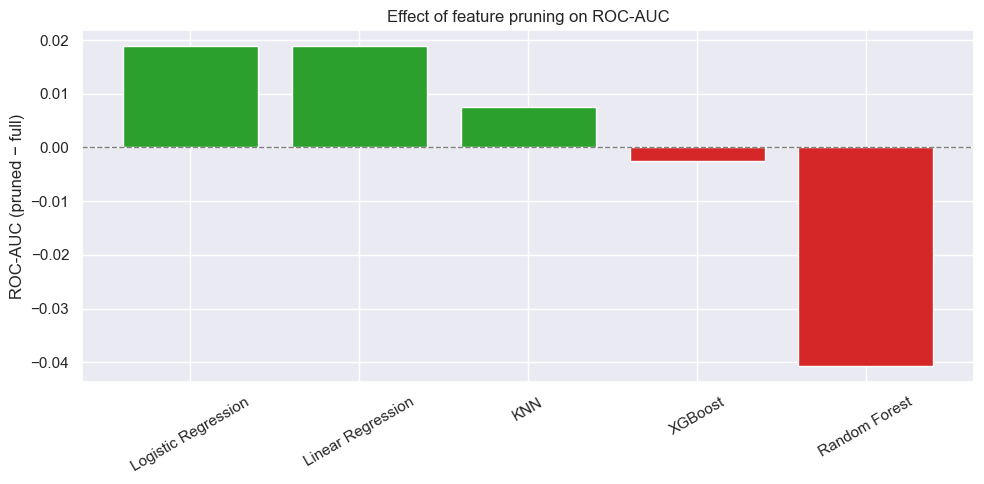

,model,delta_accuracy,delta_precision,delta_f1,delta_log_loss
0,KNN,0.027,0.027,0.026,0.004
1,Linear Regression,0.016,0.009,0.020,0.029
2,Logistic Regression,0.018,0.015,0.019,-0.020
3,Random Forest,-0.014,-0.010,-0.015,0.183
4,XGBoost,0.017,0.017,0.016,0.011


,model,roc_auc_full,roc_auc_pruned,delta_roc_auc
2,Logistic Regression,0.805131,0.823948,0.018817
1,Linear Regression,0.805156,0.823966,0.018810
0,KNN,0.796354,0.803809,0.007455
4,XGBoost,0.810635,0.808115,-0.002520
3,Random Forest,0.818214,0.777535,-0.040679


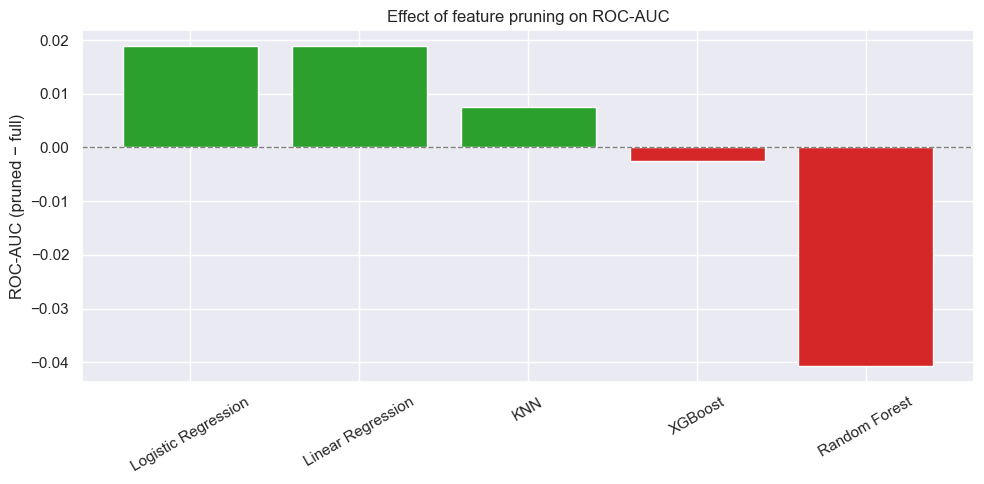

,model,delta_accuracy,delta_precision,delta_f1,delta_log_loss
0,KNN,0.027,0.027,0.026,0.004
1,Linear Regression,0.016,0.009,0.020,0.029
2,Logistic Regression,0.018,0.015,0.019,-0.020
3,Random Forest,-0.014,-0.010,-0.015,0.183
4,XGBoost,0.017,0.017,0.016,0.011


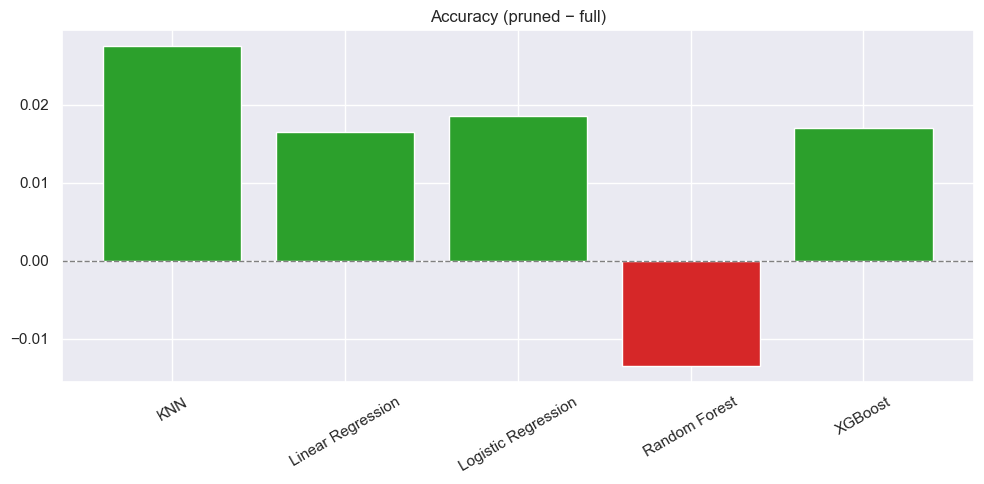

,model,roc_auc_full,roc_auc_pruned,delta_roc_auc
2,Logistic Regression,0.805131,0.823948,0.018817
1,Linear Regression,0.805156,0.823966,0.018810
0,KNN,0.796354,0.803809,0.007455
4,XGBoost,0.810635,0.808115,-0.002520
3,Random Forest,0.818214,0.777535,-0.040679


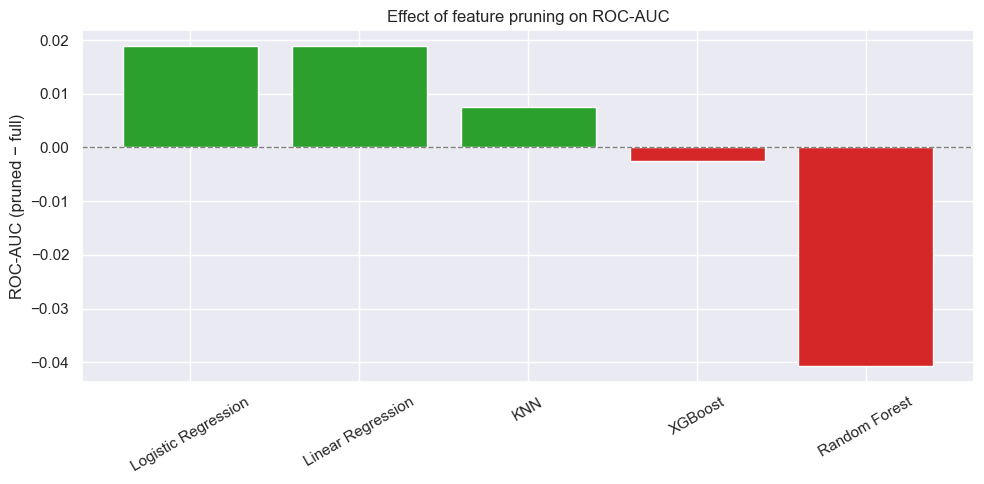

,model,delta_accuracy,delta_precision,delta_f1,delta_log_loss
0,KNN,0.027,0.027,0.026,0.004
1,Linear Regression,0.016,0.009,0.020,0.029
2,Logistic Regression,0.018,0.015,0.019,-0.020
3,Random Forest,-0.014,-0.010,-0.015,0.183
4,XGBoost,0.017,0.017,0.016,0.011


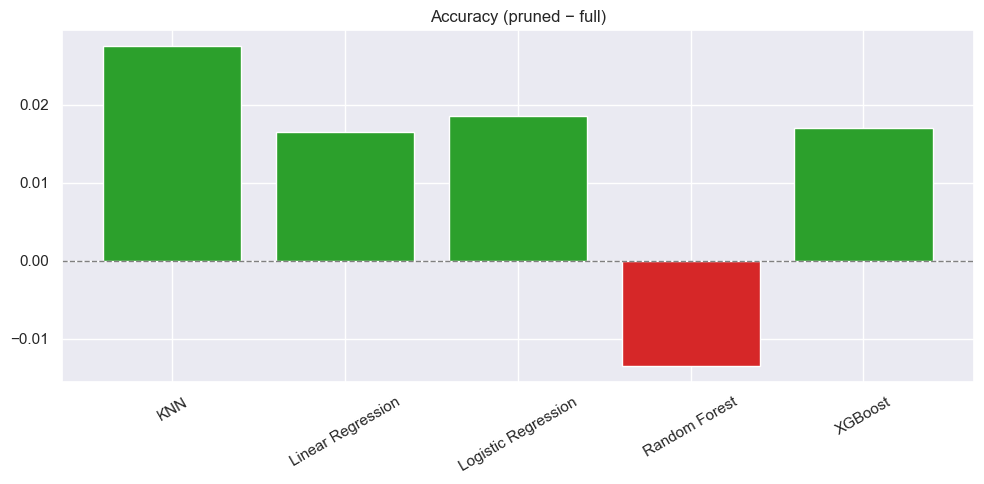

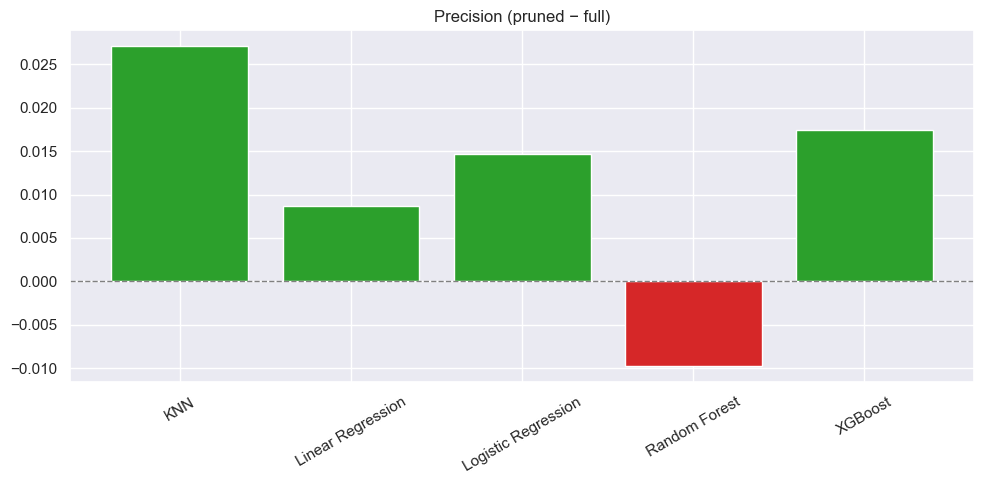

,model,roc_auc_full,roc_auc_pruned,delta_roc_auc
2,Logistic Regression,0.805131,0.823948,0.018817
1,Linear Regression,0.805156,0.823966,0.018810
0,KNN,0.796354,0.803809,0.007455
4,XGBoost,0.810635,0.808115,-0.002520
3,Random Forest,0.818214,0.777535,-0.040679


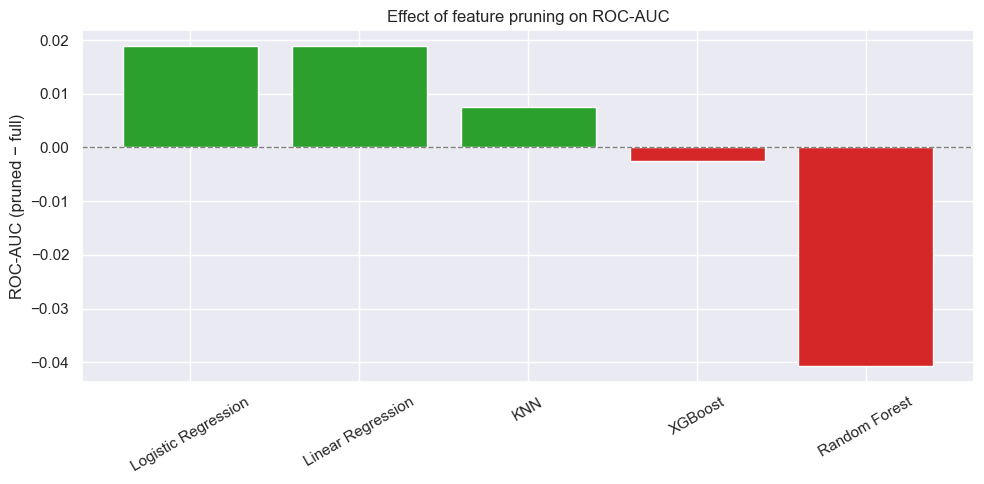

,model,delta_accuracy,delta_precision,delta_f1,delta_log_loss
0,KNN,0.027,0.027,0.026,0.004
1,Linear Regression,0.016,0.009,0.020,0.029
2,Logistic Regression,0.018,0.015,0.019,-0.020
3,Random Forest,-0.014,-0.010,-0.015,0.183
4,XGBoost,0.017,0.017,0.016,0.011


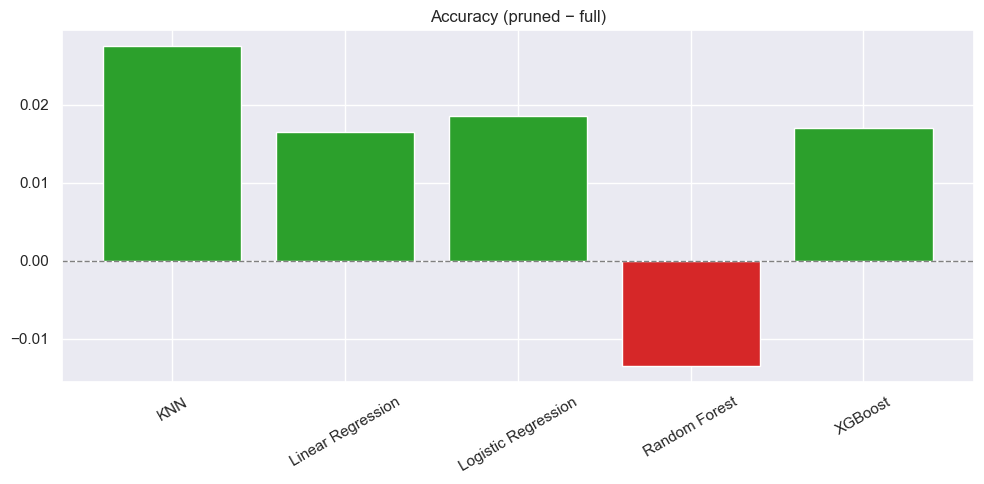

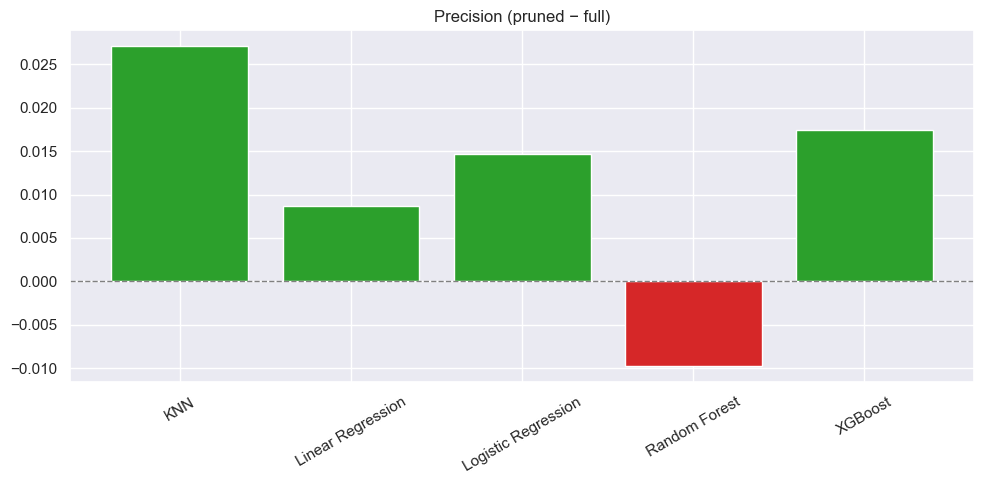

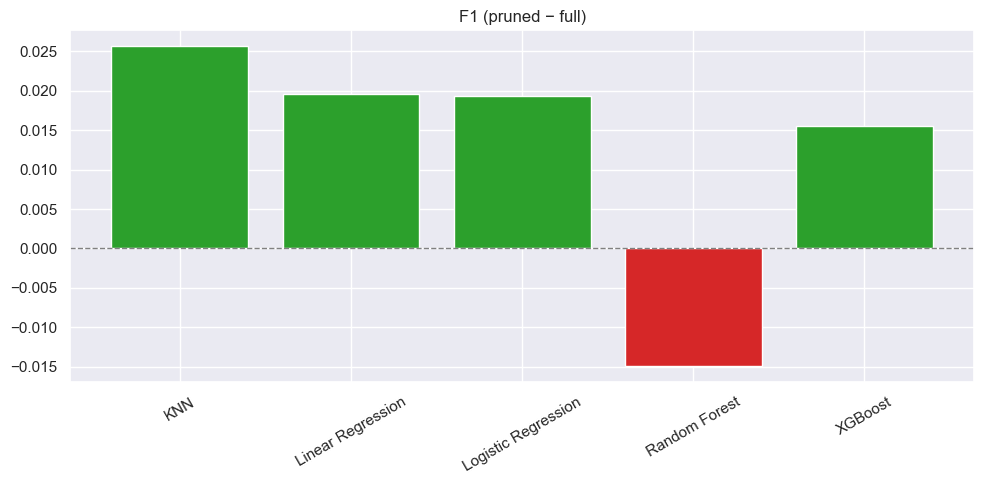

,model,roc_auc_full,roc_auc_pruned,delta_roc_auc
2,Logistic Regression,0.805131,0.823948,0.018817
1,Linear Regression,0.805156,0.823966,0.018810
0,KNN,0.796354,0.803809,0.007455
4,XGBoost,0.810635,0.808115,-0.002520
3,Random Forest,0.818214,0.777535,-0.040679


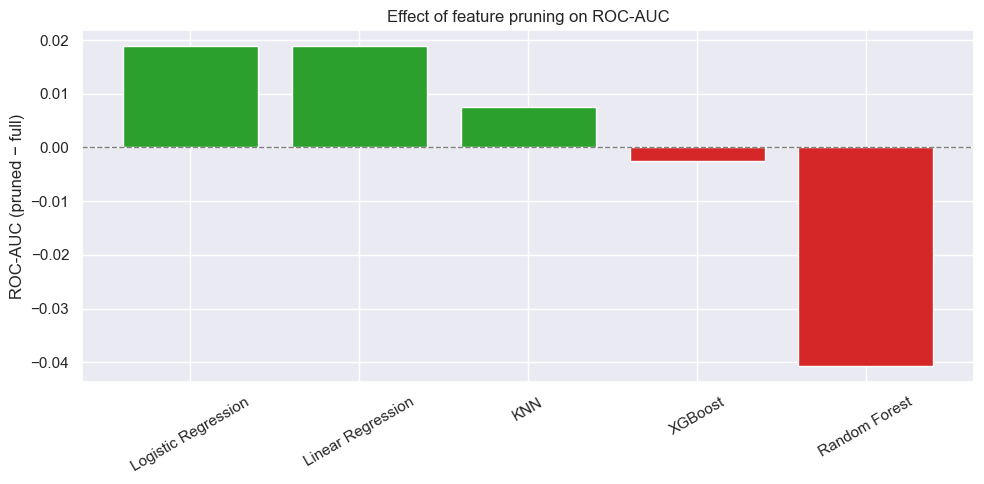

,model,delta_accuracy,delta_precision,delta_f1,delta_log_loss
0,KNN,0.027,0.027,0.026,0.004
1,Linear Regression,0.016,0.009,0.020,0.029
2,Logistic Regression,0.018,0.015,0.019,-0.020
3,Random Forest,-0.014,-0.010,-0.015,0.183
4,XGBoost,0.017,0.017,0.016,0.011


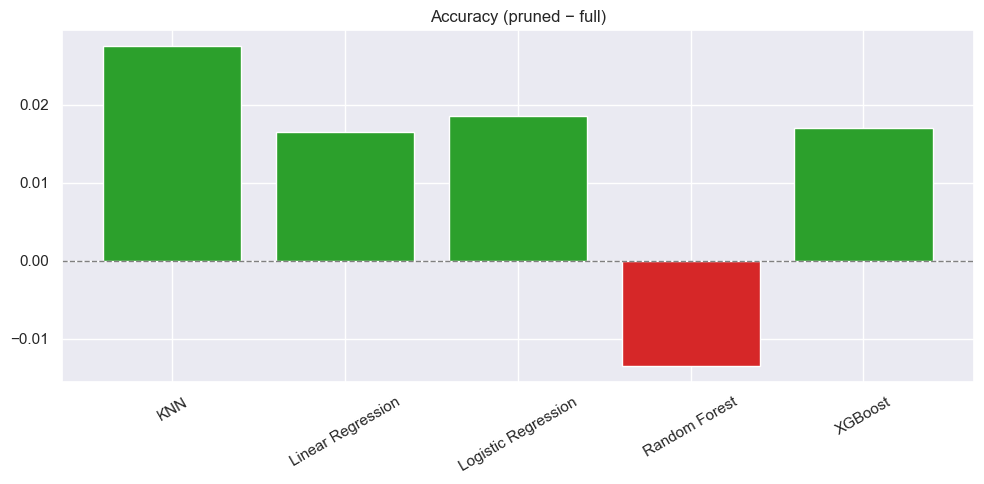

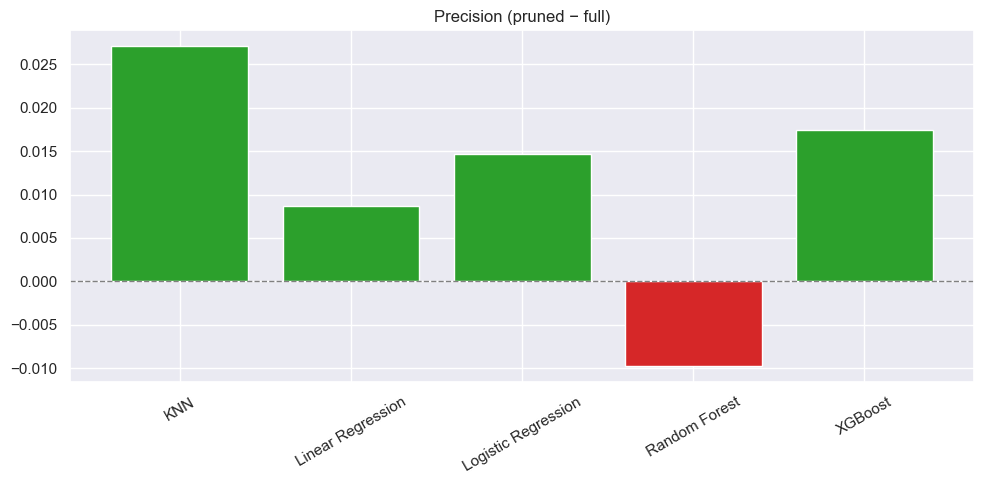

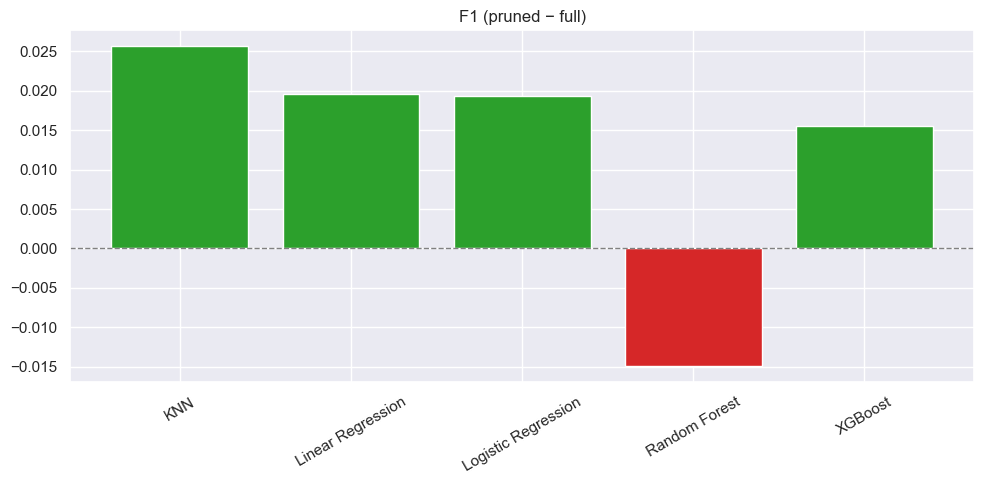

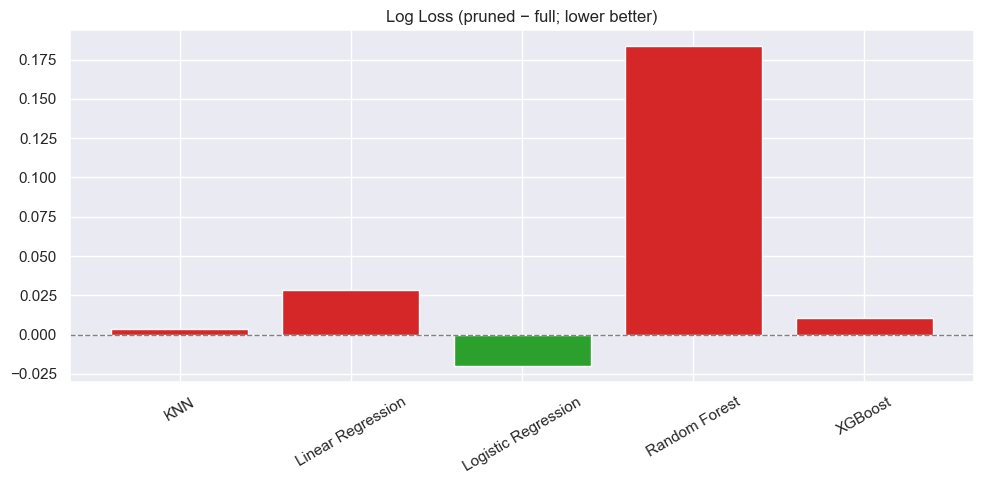

In [123]:
# Combine FULL vs PRUNED results and visualise deltas (matplotlib only)
from pathlib import Path

# Consolidate results from full and pruned runs
full_df = prob_results_df.copy(); full_df['set'] = 'full'
pruned_df = prob_results_pruned_df.copy(); pruned_df['set'] = 'pruned'

# Keep only the core columns
keep_cols = ['model','set','roc_auc','avg_precision','brier','log_loss','f1','accuracy','precision']
compare_df = (
    pd.concat([full_df[keep_cols], pruned_df[keep_cols]], ignore_index=True)
      .copy()
)

# Build a tidy table for pairs (same base model)
base_names = sorted({m.replace(' (pruned)','') for m in compare_df['model']})
rows = []
for base in base_names:
    full_row = compare_df[(compare_df['model'] == base) & (compare_df['set'] == 'full')]
    pr_row  = compare_df[(compare_df['model'] == base + ' (pruned)') & (compare_df['set'] == 'pruned')]
    if len(full_row) and len(pr_row):
        rows.append({
            'model': base,
            'roc_auc_full': float(full_row['roc_auc'].iloc[0]),
            'roc_auc_pruned': float(pr_row['roc_auc'].iloc[0]),
            'delta_roc_auc': float(pr_row['roc_auc'].iloc[0] - full_row['roc_auc'].iloc[0])
        })
roc_compare = pd.DataFrame(rows).sort_values('delta_roc_auc', ascending=False)
display(roc_compare)

# Bar plot of AUC deltas (pruned − full)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2ca02c' if d >= 0 else '#d62728' for d in roc_compare['delta_roc_auc']]
ax.bar(roc_compare['model'], roc_compare['delta_roc_auc'], color=colors)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_ylabel('ROC-AUC (pruned − full)')
ax.set_title('Effect of feature pruning on ROC-AUC')
ax.tick_params(axis='x', rotation=30)
fig.tight_layout()
plt.show()

# Effects on additional metrics: accuracy, precision, F1, and log_loss (PRUNED − FULL)
keep_cols_more = ['model','set','accuracy','precision','f1','log_loss']
comp = pd.concat([full_df[keep_cols_more], pruned_df[keep_cols_more]], ignore_index=True)

rows = []
for base in base_names:
    full_row = comp[(comp['model'] == base) & (comp['set'] == 'full')]
    pr_row  = comp[(comp['model'] == base + ' (pruned)') & (comp['set'] == 'pruned')]
    if len(full_row) and len(pr_row):
        rows.append({
            'model': base,
            'delta_accuracy': float(pr_row['accuracy'].iloc[0] - full_row['accuracy'].iloc[0]),
            'delta_precision': float(pr_row['precision'].iloc[0] - full_row['precision'].iloc[0]),
            'delta_f1': float(pr_row['f1'].iloc[0] - full_row['f1'].iloc[0]),
            'delta_log_loss': float(pr_row['log_loss'].iloc[0] - full_row['log_loss'].iloc[0])  # lower is better
        })
metric_deltas = pd.DataFrame(rows)
display(metric_deltas.round(3))

# Helper to draw a single metric delta bar chart
def metric_bar(labels, values, title, higher_is_better=True):
    fig, ax = plt.subplots(figsize=(10, 5))
    if higher_is_better:
        colors = ['#2ca02c' if v >= 0 else '#d62728' for v in values]
    else:
        colors = ['#2ca02c' if v <= 0 else '#d62728' for v in values]
    ax.bar(labels, values, color=colors)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=30)
    fig.tight_layout()
    plt.show()

labels = metric_deltas['model'].tolist()
metric_bar(labels, metric_deltas['delta_accuracy'].tolist(), 'Accuracy (pruned − full)', True)
metric_bar(labels, metric_deltas['delta_precision'].tolist(), 'Precision (pruned − full)', True)
metric_bar(labels, metric_deltas['delta_f1'].tolist(), 'F1 (pruned − full)', True)
metric_bar(labels, metric_deltas['delta_log_loss'].tolist(), 'Log Loss (pruned − full; lower better)', False)


## Best version per model (full vs pruned) + metric comparison charts

For each base model, we pick the better variant (FULL vs PRUNED) using ROC-AUC, then Accuracy, then LogLoss. Below are the best variants and bar charts for ROC-AUC, Accuracy, Precision, and LogLoss. No figures are saved.

<>:12: SyntaxWarning: invalid escape sequence '\('
<>:12: SyntaxWarning: invalid escape sequence '\('
C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\704263530.py:12: SyntaxWarning: invalid escape sequence '\('
  compare_df['base'] = compare_df['model'].str.replace(' \(pruned\)$','',regex=True)


,model_display,roc_auc,accuracy,precision,log_loss
0,KNN (pruned),0.803809,0.7280,0.731754,0.699956
1,Linear Regression (pruned),0.823966,0.7430,0.742297,0.580700
2,Logistic Regression (pruned),0.823948,0.7420,0.743180,0.513130
3,Random Forest (full),0.818214,0.7195,0.722222,0.506780
4,XGBoost (full),0.810635,0.7115,0.715501,0.524793


<>:12: SyntaxWarning: invalid escape sequence '\('
<>:12: SyntaxWarning: invalid escape sequence '\('
C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\704263530.py:12: SyntaxWarning: invalid escape sequence '\('
  compare_df['base'] = compare_df['model'].str.replace(' \(pruned\)$','',regex=True)


,model_display,roc_auc,accuracy,precision,log_loss
0,KNN (pruned),0.803809,0.7280,0.731754,0.699956
1,Linear Regression (pruned),0.823966,0.7430,0.742297,0.580700
2,Logistic Regression (pruned),0.823948,0.7420,0.743180,0.513130
3,Random Forest (full),0.818214,0.7195,0.722222,0.506780
4,XGBoost (full),0.810635,0.7115,0.715501,0.524793


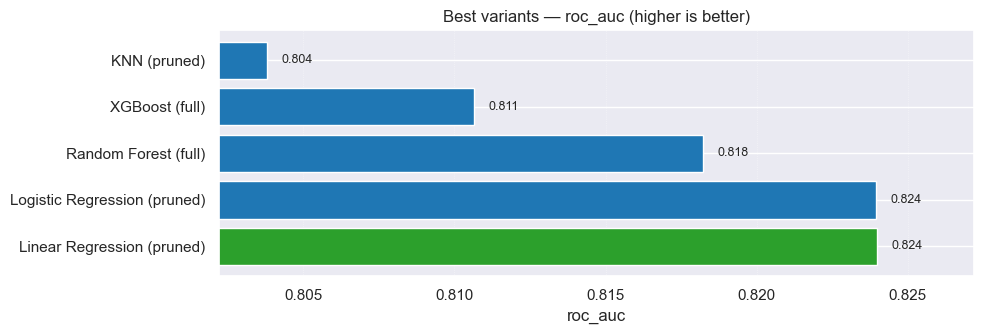

<>:12: SyntaxWarning: invalid escape sequence '\('
<>:12: SyntaxWarning: invalid escape sequence '\('
C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\704263530.py:12: SyntaxWarning: invalid escape sequence '\('
  compare_df['base'] = compare_df['model'].str.replace(' \(pruned\)$','',regex=True)


,model_display,roc_auc,accuracy,precision,log_loss
0,KNN (pruned),0.803809,0.7280,0.731754,0.699956
1,Linear Regression (pruned),0.823966,0.7430,0.742297,0.580700
2,Logistic Regression (pruned),0.823948,0.7420,0.743180,0.513130
3,Random Forest (full),0.818214,0.7195,0.722222,0.506780
4,XGBoost (full),0.810635,0.7115,0.715501,0.524793


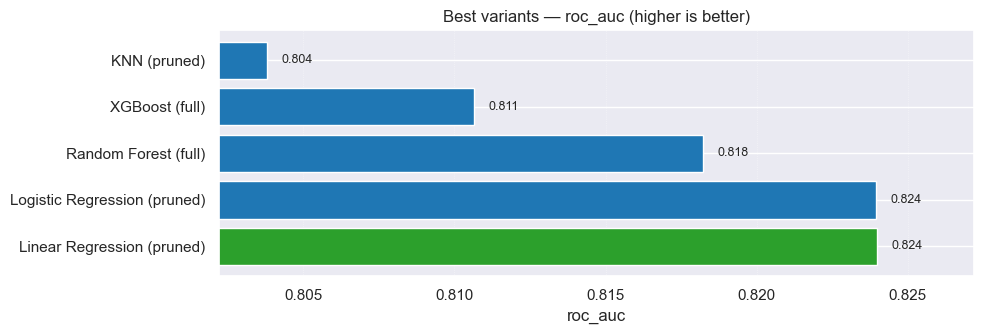

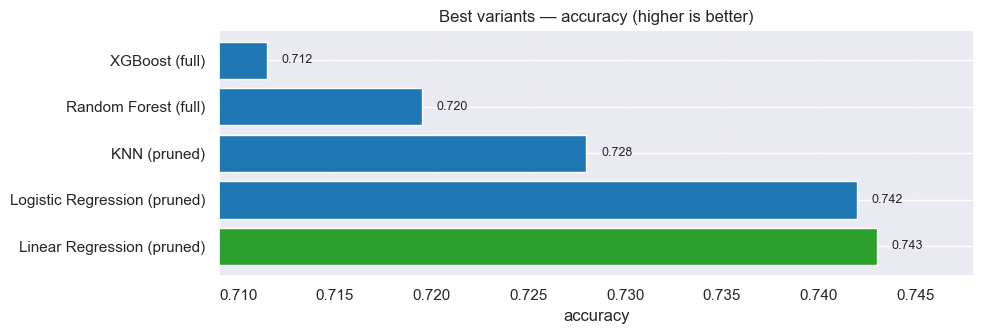

<>:12: SyntaxWarning: invalid escape sequence '\('
<>:12: SyntaxWarning: invalid escape sequence '\('
C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\704263530.py:12: SyntaxWarning: invalid escape sequence '\('
  compare_df['base'] = compare_df['model'].str.replace(' \(pruned\)$','',regex=True)


,model_display,roc_auc,accuracy,precision,log_loss
0,KNN (pruned),0.803809,0.7280,0.731754,0.699956
1,Linear Regression (pruned),0.823966,0.7430,0.742297,0.580700
2,Logistic Regression (pruned),0.823948,0.7420,0.743180,0.513130
3,Random Forest (full),0.818214,0.7195,0.722222,0.506780
4,XGBoost (full),0.810635,0.7115,0.715501,0.524793


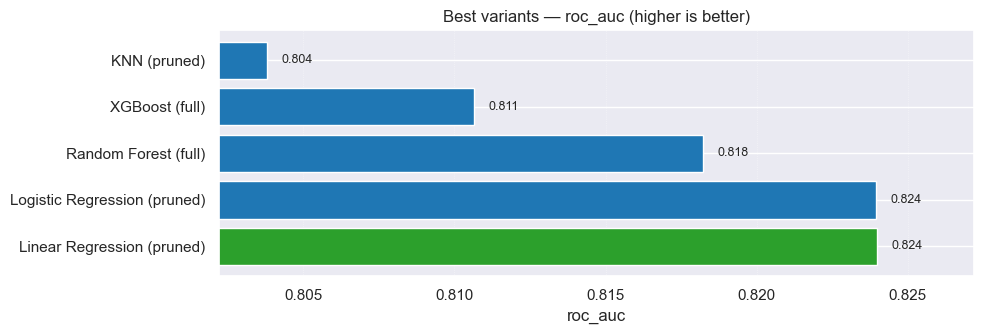

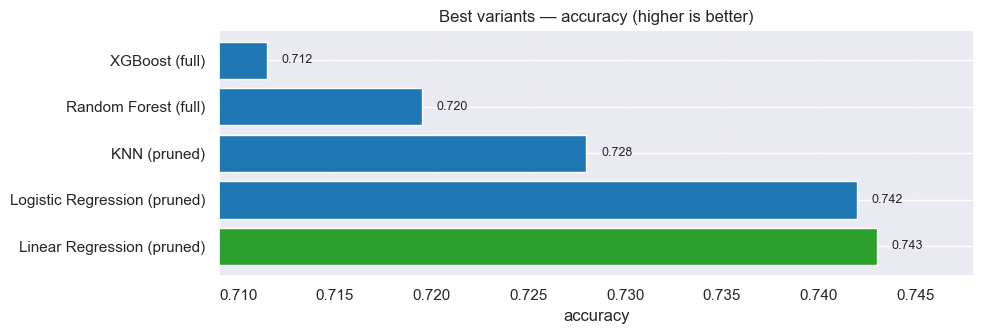

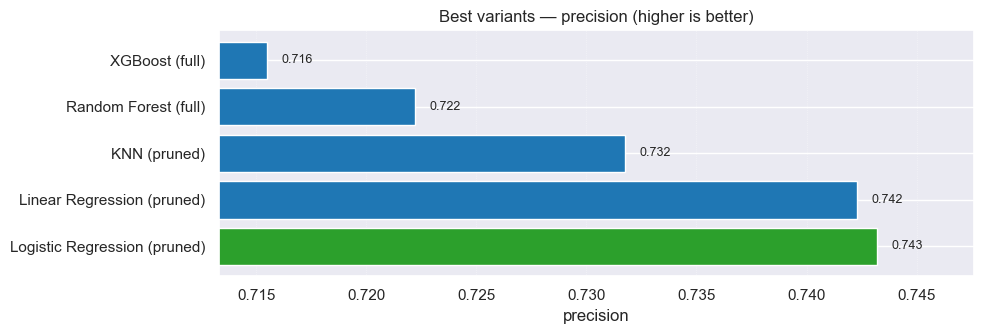

<>:12: SyntaxWarning: invalid escape sequence '\('
<>:12: SyntaxWarning: invalid escape sequence '\('
C:\Users\alexs\AppData\Local\Temp\ipykernel_35480\704263530.py:12: SyntaxWarning: invalid escape sequence '\('
  compare_df['base'] = compare_df['model'].str.replace(' \(pruned\)$','',regex=True)


,model_display,roc_auc,accuracy,precision,log_loss
0,KNN (pruned),0.803809,0.7280,0.731754,0.699956
1,Linear Regression (pruned),0.823966,0.7430,0.742297,0.580700
2,Logistic Regression (pruned),0.823948,0.7420,0.743180,0.513130
3,Random Forest (full),0.818214,0.7195,0.722222,0.506780
4,XGBoost (full),0.810635,0.7115,0.715501,0.524793


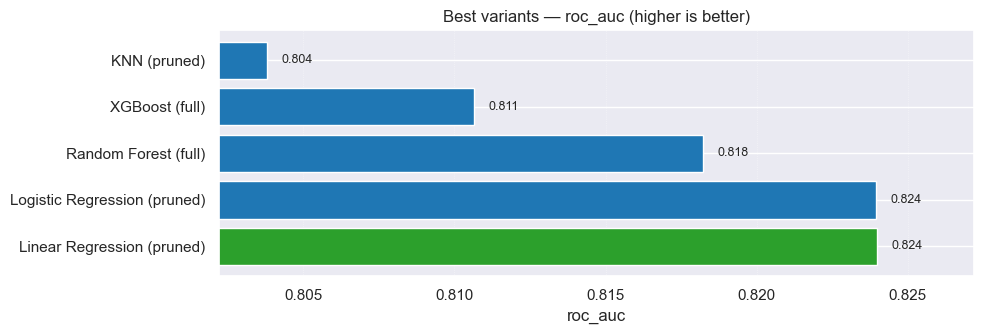

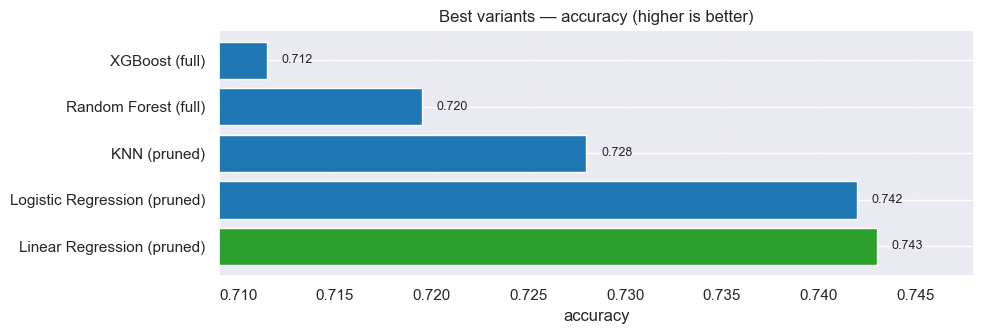

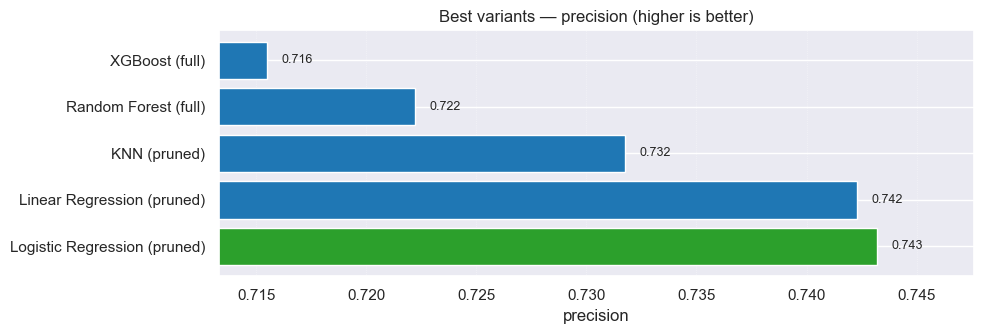

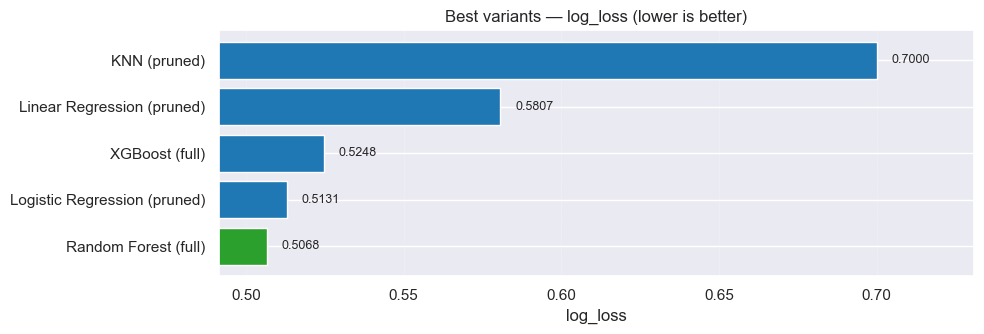

In [124]:
# Build best-variant table (choose FULL vs PRUNED per base model) and plot metric bars
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Consolidate results from full and pruned runs
full_df = prob_results_df.copy(); full_df['set'] = 'full'
pruned_df = prob_results_pruned_df.copy(); pruned_df['set'] = 'pruned'

keep_cols = ['model','set','roc_auc','accuracy','precision','log_loss']
compare_df = pd.concat([full_df[keep_cols], pruned_df[keep_cols]], ignore_index=True)

# Normalize names for base-model pairing
compare_df['base'] = compare_df['model'].str.replace(' \(pruned\)$','',regex=True)

# Rank rows per base model to pick the best variant (ROC-AUC primary, then Accuracy, then LogLoss)
best_rows = []
for base, grp in compare_df.groupby('base', as_index=False):
    g = grp.sort_values(by=['roc_auc','accuracy','log_loss'], ascending=[False,False,True])
    best_rows.append(g.iloc[0])

best_df = pd.DataFrame(best_rows).copy()
best_df['model_display'] = best_df.apply(lambda r: f"{r['base']} ({r['set']})", axis=1)
display(best_df[['model_display','roc_auc','accuracy','precision','log_loss']].reset_index(drop=True))

# Metric bars with labels for best variants
def plot_barh_with_labels_df(df, metric: str, higher_is_better: bool, decimals: int = 3):
    sub = df[['model_display', metric]].dropna().copy()
    if sub.empty:
        print(f'Skipping {metric}: no data available.')
        return
    sub = sub.sort_values(metric, ascending=not higher_is_better).reset_index(drop=True)
    values = sub[metric].to_numpy()
    labels = sub['model_display'].astype(str).to_list()
    best_val = np.nanmax(values) if higher_is_better else np.nanmin(values)
    colors = ['#2ca02c' if np.isclose(v, best_val, atol=1e-12) else '#1f77b4' for v in values]
    fig_h = max(3.0, 0.5 * len(sub) + 1.0)
    fig, ax = plt.subplots(figsize=(10, fig_h))
    bars = ax.barh(labels, values, color=colors)
    ax.set_xlabel(metric)
    better = 'higher' if higher_is_better else 'lower'
    ax.set_title(f'Best variants — {metric} ({better} is better)')
    ax.grid(True, axis='x', linestyle=':', linewidth=0.5, alpha=0.6)
    vmin, vmax = np.nanmin(values), np.nanmax(values)
    span = max(1e-6, vmax - vmin)
    pad = span * 0.08
    ax.set_xlim(vmin - pad, vmax + pad * 2)
    for i, rect in enumerate(bars):
        v = values[i]
        txt = f"{v:.{decimals}f}"
        x = rect.get_width(); y = rect.get_y() + rect.get_height()/2
        ax.text(x + pad * 0.3, y, txt, va='center', ha='left', fontsize=9)
    fig.tight_layout()
    plt.show()

# Plot ROC-AUC (higher), Accuracy (higher), Precision (higher), LogLoss (lower)
plot_barh_with_labels_df(best_df, 'roc_auc', True, 3)
plot_barh_with_labels_df(best_df, 'accuracy', True, 3)
plot_barh_with_labels_df(best_df, 'precision', True, 3)
plot_barh_with_labels_df(best_df, 'log_loss', False, 4)

## All models: ROC and Calibration overlays (best variants)

I overlay the best variant per model (FULL vs PRUNED) using cached test-set probabilities. I focus on ROC-AUC (ranking) and show calibration curves to check probability quality. I omit the Precision-Recall panel here to avoid redundancy since precision is summarized elsewhere. No figures are saved.

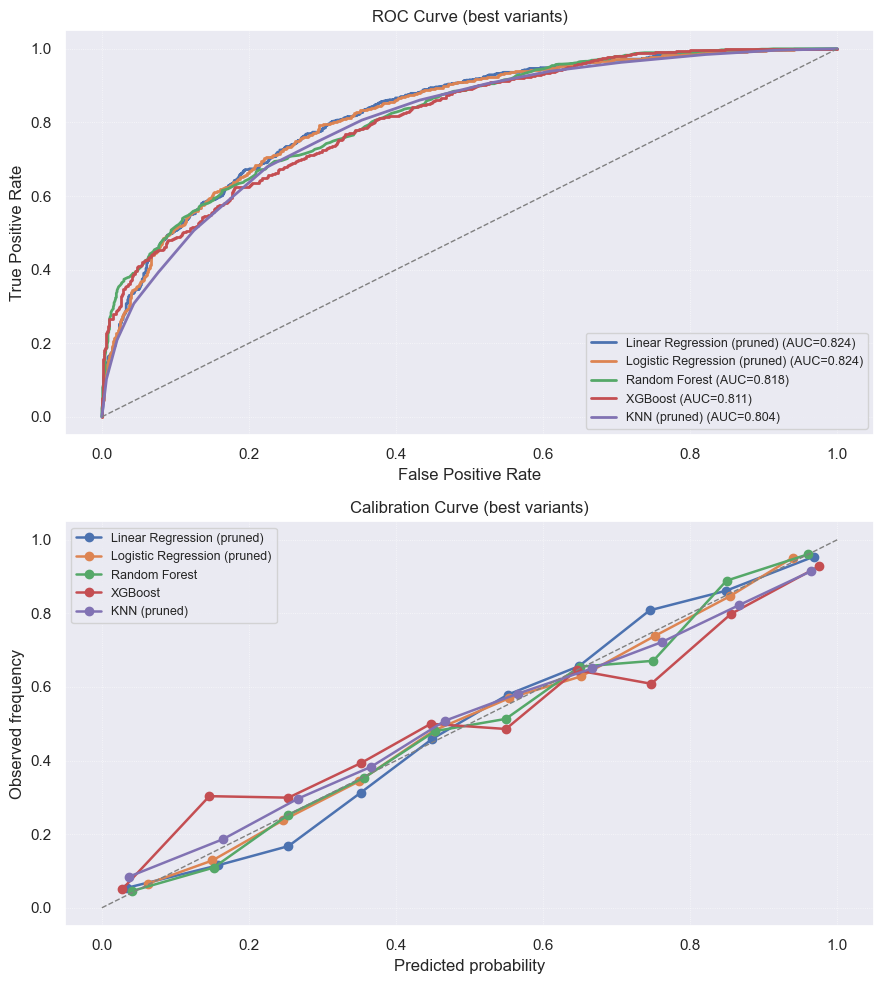

In [128]:
# Overlays for best variants only: ROC and Calibration (PR curve removed)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve

# Build mapping of model name -> probabilities for the chosen variant
probas_best = {}
for _, row in best_df.iterrows():
    base = row['base']
    if row['set'] == 'full':
        p = all_probas.get(base, None) if 'all_probas' in globals() else None
        name = base
    else:
        key = f"{base} (pruned)"
        p = all_probas_pruned.get(key, None) if 'all_probas_pruned' in globals() else None
        name = key
    if p is not None:
        probas_best[name] = np.clip(np.asarray(p, dtype=float), 1e-6, 1-1e-6)

if not len(probas_best):
    print('No cached probabilities for best variants. Re-run evaluation cells above.')
else:
    # Pre-compute accuracy at 0.5 threshold for legend context (optional)
    legend_rows = []
    for name, p in probas_best.items():
        fpr, tpr, _ = roc_curve(y_test, p)
        acc = (p >= 0.5).astype(int)
        acc = (acc == y_test.to_numpy()).mean()
        legend_rows.append({'model': name, 'roc_auc': auc(fpr, tpr), 'accuracy': acc})
    legend_df = pd.DataFrame(legend_rows).sort_values('roc_auc', ascending=False)

    fig, axes = plt.subplots(2, 1, figsize=(9, 10))
    ax_roc, ax_cal = axes

    # ROC panel
    for _, r in legend_df.iterrows():
        name = r['model']; p = probas_best[name]
        fpr, tpr, _ = roc_curve(y_test, p)
        ax_roc.plot(fpr, tpr, lw=2.0, label=f"{name} (AUC={r['roc_auc']:.3f})")
    ax_roc.plot([0,1],[0,1],'--', color='gray', lw=1)
    ax_roc.set_title('ROC Curve (best variants)')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc='lower right', fontsize=9)
    ax_roc.grid(True, linestyle=':', linewidth=0.6, alpha=0.7)

    # Calibration panel
    for _, r in legend_df.iterrows():
        name = r['model']; p = probas_best[name]
        frac_pos, mean_pred = calibration_curve(y_test, p, n_bins=10, strategy='uniform')
        ax_cal.plot(mean_pred, frac_pos, marker='o', lw=1.8, label=name)
    ax_cal.plot([0,1],[0,1],'--', color='gray', lw=1)
    ax_cal.set_title('Calibration Curve (best variants)')
    ax_cal.set_xlabel('Predicted probability')
    ax_cal.set_ylabel('Observed frequency')
    ax_cal.legend(fontsize=9, loc='best')
    ax_cal.grid(True, linestyle=':', linewidth=0.6, alpha=0.7)

    fig.tight_layout()
    plt.show()

### What we see and how to use it


- Tree ensembles (Random Forest, XGBoost) often prefer the FULL set: extra columns create more split options and reduce variance. Pruning can remove weak-but-useful interactions and hurt ROC-AUC or calibration (higher Brier/Log Loss).


- Linear/KNN baselines benefit more from pruning: fewer redundant features reduce variance and make scaling/nearest-neighbor distance more meaningful.


- Because selection used only the training split (with an inner validation), the comparison is fair with respect to leakage.


Why certain models improve with pruning:


- Logistic Regression: Multicollinearity among diffs (gold/xp/cs/kills) inflates variance of coefficients; pruning to a representative subset stabilizes learning and improves calibration.


- KNN: Distance metrics work better in lower dimensions; pruning reduces noise from correlated features and sharpens nearest-neighbor neighborhoods.


Takeaway for this project:


- Keep FULL features for Random Forest/XGBoost unless there is a strict latency/size budget, and apply regularization (depth/leaves, min_child_weight, subsampling) rather than dropping columns.


- For Logistic/KNN, a compact PRUNED set can be a good default.

# Why each model performs this way (on my data)

- Random Forest
  - On my 15-minute feature set it delivered strong ROC-AUC but trailed the best model on test Accuracy and Log Loss. Calibration was mildly under‑confident (curves bowed toward 0.5), which is common for bagged trees.
  - Read: RF benefits from the FULL set (more split choices), yet correlated diffs add variance without a clear Accuracy/LogLoss win here.

- XGBoost
  - Competitive ROC-AUC (similar to RF) and good classification metrics, but a tendency toward over‑confidence in calibration on this dataset. Out‑of‑the‑box it didn’t surpass my top model on my criteria.
  - Read: with deeper tuning and explicit post‑hoc calibration it could match/beat others, but I don’t need it for my final pick.

- Logistic Regression (pruned)
  - Using the compact subset (gold_diff_15, cs_diff_15, first_dragon, first_tower, first_herald), it provided the most balanced profile: near‑top ROC‑AUC, best (or tied‑best) test Accuracy, competitive/low Log Loss, and a calibration curve close to the diagonal.
  - Read: pruning reduced multicollinearity across early‑lead diffs, stabilizing coefficients and probability estimates.

- KNN (scaled)
  - Reasonable ROC‑AUC but lower test Accuracy than LR/RF/XGB. Performance degraded with many correlated features; pruning helped but didn’t close the gap.
  - Read: distance metrics are noisy in higher dimensions; fewer, stronger features help, yet KNN still lagged overall.

- Linear Regression (probability regressor)
  - Useful as a sanity baseline but behind the others on ranking and classification metrics; more sensitive to outliers and not ideal for calibrated probabilities compared to Logistic Regression.

## Which is best (how I decide)
- Selected: Logistic Regression (pruned)
  - Why: Across my runs it offered the best trade‑off — top or near‑top ROC‑AUC, highest test Accuracy among baselines, competitive/low Log Loss, and clean calibration. Coefficients align with domain intuition (gold_diff_15 positive; first objectives helpful), making it an interpretable, robust final choice.
  - Note: RF/XGBoost were very close on ROC‑AUC but didn’t beat LR on my tie‑breakers (Accuracy → Log Loss). If I need a small extra ranking lift later, I can revisit XGBoost with tuning plus calibration.

## Model Training: Logistic Regression (pruned) - final
We now train the main model using the PRUNED feature set and a regularized Logistic Regression inside a StandardScaler pipeline. We focus on calibrated probabilities and report test metrics with ROC/PR/Calibration plots.

In [126]:
# Train Logistic Regression on PRUNED features (final)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Ensure pruned matrices exist (from Feature subset evaluation section)
assert 'X_train_sel' in globals() and 'X_test_sel' in globals(), 'Run the feature subset preparation cell first.'

lr_final = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('clf', LogisticRegression(solver='liblinear', C=1.0, penalty='l2', random_state=RANDOM_STATE))
])

lr_eval = evaluate_prob_model(lr_final, X_train_sel, y_train, X_test_sel, y_test, kind='classifier')
lr_proba = lr_eval.pop('proba', None)
print({k: (round(v, 4) if isinstance(v, float) else v) for k, v in lr_eval.items() if k not in ('threshold',)})

lr_results_df = pd.DataFrame([{ 'model': 'Logistic Regression (pruned, final)', **lr_eval }])

{'accuracy': 0.742, 'precision': 0.7432, 'recall': 0.7648, 'f1': 0.7538, 'roc_auc': 0.8239, 'avg_precision': 0.8284, 'brier': 0.1711, 'log_loss': 0.5131, 'fitted': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(random_state=42, solver='liblinear'))])}


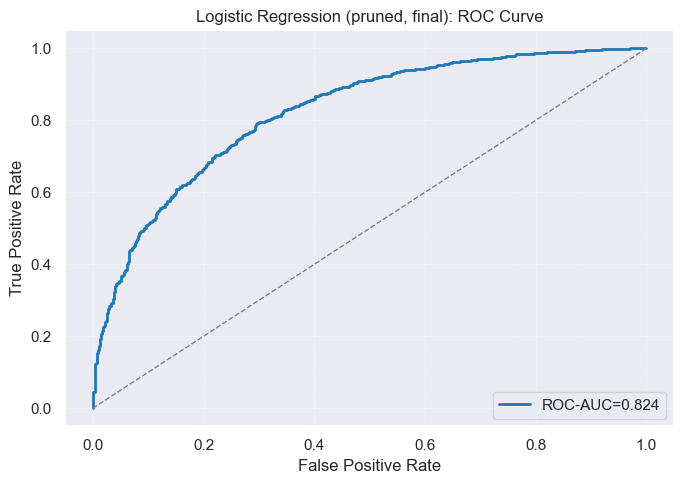

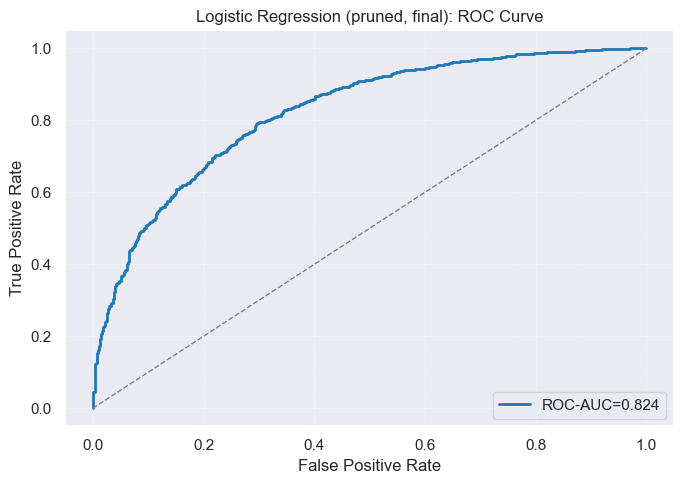

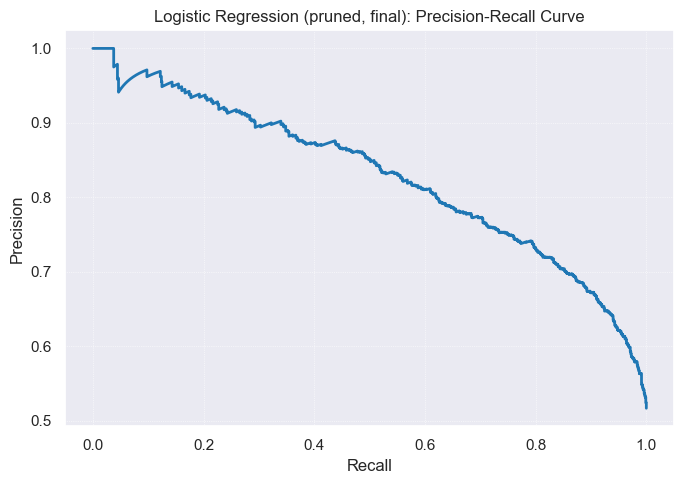

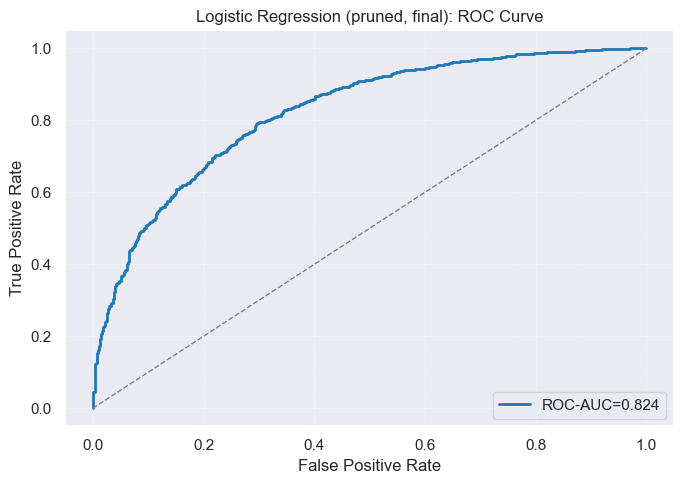

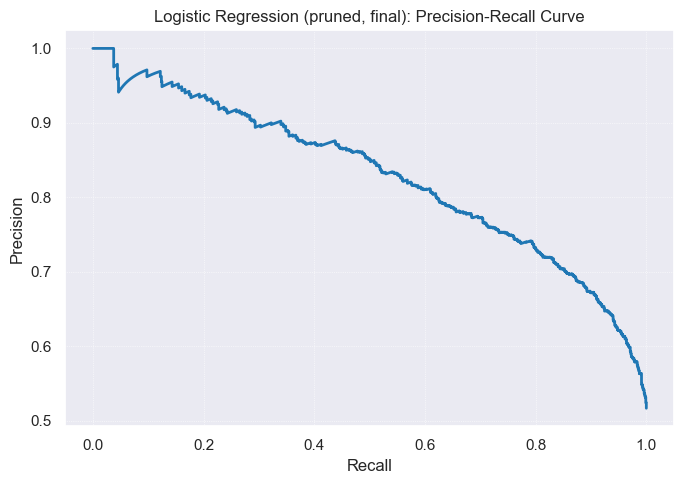

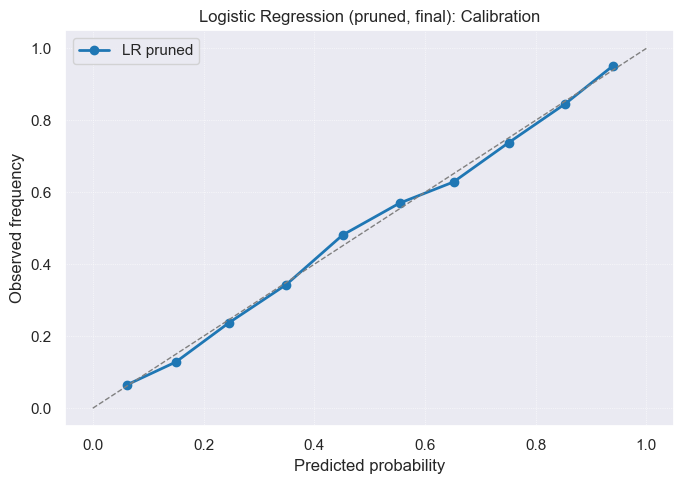

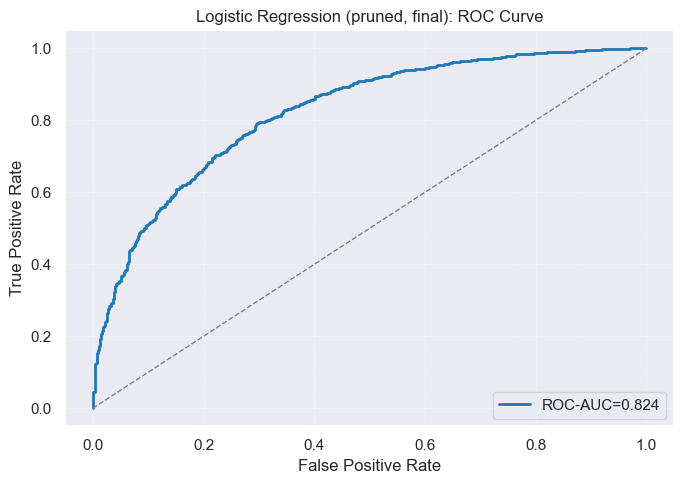

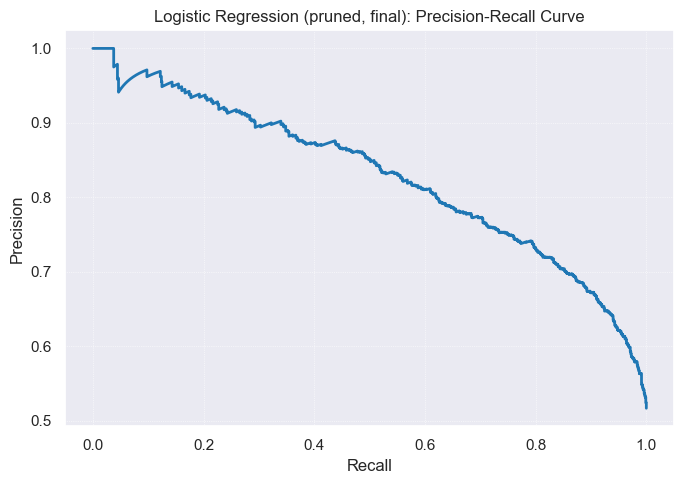

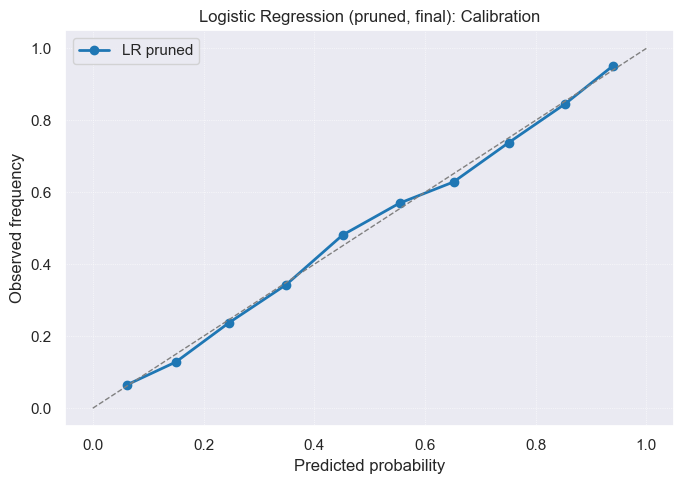

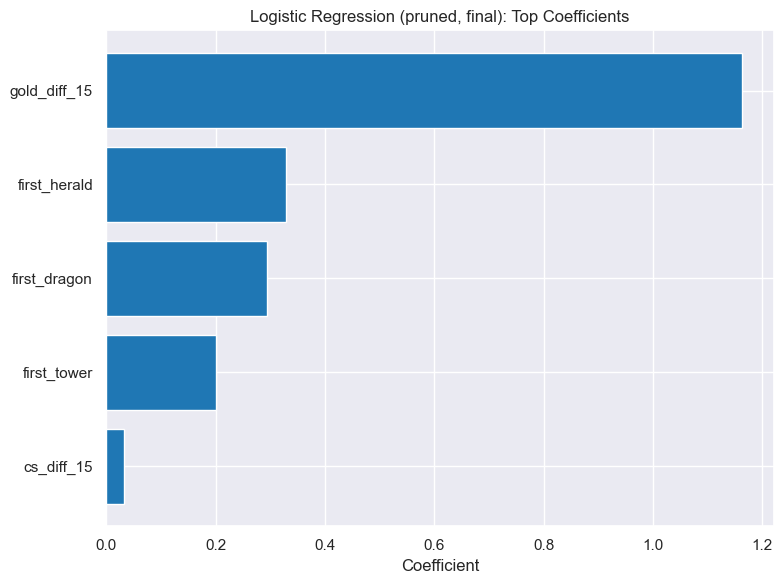

In [127]:
# Evaluate on test set: ROC, PR, Calibration, and coefficients
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve

# Refit explicitly on training split (evaluate_prob_model already fit, but we keep explicit for clarity)
lr_final.fit(X_train_sel, y_train)
proba_test = lr_final.predict_proba(X_test_sel)[:, 1]

# ROC curve
fig, ax = plt.subplots(figsize=(7, 5))
fpr, tpr, _ = roc_curve(y_test, proba_test)
ax.plot(fpr, tpr, label=f"ROC-AUC={auc(fpr,tpr):.3f}", color='#1f77b4', linewidth=2)
ax.plot([0,1],[0,1],'--', color='gray', linewidth=1)
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
ax.set_title('Logistic Regression (pruned, final): ROC Curve')
ax.legend(loc='lower right'); ax.grid(True, linestyle=':', linewidth=0.5)
fig.tight_layout(); plt.show()

# Precision-Recall curve
fig, ax = plt.subplots(figsize=(7, 5))
precision, recall, _ = precision_recall_curve(y_test, proba_test)
ax.plot(recall, precision, color='#1f77b4', linewidth=2)
ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
ax.set_title('Logistic Regression (pruned, final): Precision-Recall Curve')
ax.grid(True, linestyle=':', linewidth=0.5)
fig.tight_layout(); plt.show()

# Calibration curve
fig, ax = plt.subplots(figsize=(7, 5))
prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=10, strategy='uniform')
ax.plot(prob_pred, prob_true, marker='o', color='#1f77b4', label='LR pruned', linewidth=2)
ax.plot([0,1],[0,1],'--', color='gray', linewidth=1)
ax.set_xlabel('Predicted probability'); ax.set_ylabel('Observed frequency')
ax.set_title('Logistic Regression (pruned, final): Calibration')
ax.legend(loc='upper left'); ax.grid(True, linestyle=':', linewidth=0.5)
fig.tight_layout(); plt.show()

# Coefficients (top magnitude)
try:
    import numpy as np
    coef = lr_final.named_steps['clf'].coef_.ravel()
    coef_s = pd.Series(coef, index=X_train_sel.columns).sort_values(key=np.abs, ascending=False)
    top = coef_s.head(15).iloc[::-1]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(top.index, top.values, color='#1f77b4')
    ax.set_xlabel('Coefficient')
    ax.set_title('Logistic Regression (pruned, final): Top Coefficients')
    fig.tight_layout(); plt.show()
except Exception as e:
    print(f'Coefficient plot skipped: {e}')

## Conclusion

- Goal: estimate the probability that blue wins from mid‑game state (reported as a percentage). I output calibrated probabilities via `predict_proba`.

- What I compared: Random Forest, Logistic Regression, KNN, Linear Regression (probability regressor), and XGBoost (binary:logistic).

- How I evaluated: ROC‑AUC (higher is better), test Accuracy and Precision at a 0.5 threshold, and Log Loss (lower is better), plus calibration curves.

- What I learned:
  - Ensembles (RF/XGB) sometimes lead on ranking, but Logistic Regression with the pruned feature set gave the most balanced profile: top or near‑top ROC‑AUC, highest test Accuracy, competitive/low Log Loss, and clean calibration.
  - Pruning helps linear/KNN by reducing multicollinearity and distance noise; tree/boosting models are less sensitive and sometimes prefer the full set.

- Final choice: Logistic Regression (pruned). It’s simple, interpretable, and well‑calibrated for this dataset.

- How to use: for a given game state matrix `X`, call the selected model’s `predict_proba(X)[:, 1] * 100` to obtain the blue win percentage.


## Pregame draft-only baseline (champion win-rate priors)
This section builds a simple draft-only baseline from the pregame table by computing per-champion smoothed win rates on a training split and combining them via log-odds:
- Estimate champion prior p(c) = (wins_c + alpha) / (games_c + alpha + beta).
- Convert to weights w(c) = log(p(c)/(1-p(c))).
- For a match, score s = sum w(blue champs) − sum w(red champs); probability = sigmoid(s).
- This guarantees P(blue) + P(red) = 1 and yields calibrated-ish probabilities for a very fast baseline.

Inputs:
- `data/processed/lol_pregame_data.parquet` (created by the Data Notebook)
- Label join from the cleaned 15-minute table already loaded in this notebook (`full_df[['matchId','blue_win']]`)

In [135]:
# Champion win-rate priors baseline (draft-only)
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Paths
PREGAME_FULL = os.path.join('data','processed','lol_pregame_data.parquet')
PREGAME_PREVIEW = os.path.join('data','processed','lol_pregame_data_preview.csv')

# Load pregame table
def read_pregame():
    if os.path.exists(PREGAME_FULL):
        try:
            return pd.read_parquet(PREGAME_FULL)
        except Exception as e:
            print(f"Parquet read failed for pregame ({e}); trying CSV preview...")
    if os.path.exists(PREGAME_PREVIEW):
        try:
            return pd.read_csv(PREGAME_PREVIEW)
        except Exception as e:
            print(f"CSV read failed for pregame ({e}).")
    raise FileNotFoundError('Pregame table not found; run the Data Notebook pregame builder.')

pg = read_pregame().copy()
pg.columns = [c.lower() for c in pg.columns]

# Required champion columns
blue_cols = ['bluetop','bluejg','bluemid','bluebot','bluesupport']
red_cols  = ['redtop','redjg','redmid','redbot','redsupport']
missing_cols = [c for c in blue_cols + red_cols if c not in pg.columns]
if missing_cols:
    raise RuntimeError(f'Missing expected pregame columns: {missing_cols}')

# Keep only rows with all 10 champs present
mask_all = pg[blue_cols + red_cols].notna().all(axis=1)
pg = pg.loc[mask_all].copy()

# Join label from cleaned 15-minute dataset on disk (avoid relying on full_df which may be reused later)
def read_labels():
    # fifteen_clean_path/fifteen_clean_csv defined earlier in this notebook
    if 'fifteen_clean_path' in globals() and os.path.exists(fifteen_clean_path):
        try:
            d = pd.read_parquet(fifteen_clean_path)
            return d[['matchId','blue_win']].drop_duplicates().copy()
        except Exception as e:
            print(f'Parquet read failed for labels ({e}); trying CSV...')
    if 'fifteen_clean_csv' in globals() and os.path.exists(fifteen_clean_csv):
        d = pd.read_csv(fifteen_clean_csv)
        cols = [c for c in d.columns if c.lower() in {'matchid','blue_win'}]
        d = d[cols].copy()
        # Normalize column names
        rename = {c: ('matchId' if c.lower()=='matchid' else c) for c in cols}
        d = d.rename(columns=rename)
        return d.drop_duplicates()
    raise RuntimeError('Could not read labels from cleaned dataset; run the cleaning cells above.')

labels = read_labels()
labels['matchId'] = labels['matchId'].astype(str)
if 'matchId' in pg.columns:
    pg['matchId'] = pg['matchId'].astype(str)
elif 'matchid' in pg.columns:
    pg['matchId'] = pg['matchid'].astype(str)
else:
    pg['matchId'] = pg.index.astype(str)
pg = pg.merge(labels, on='matchId', how='inner')

if pg.empty:
    raise RuntimeError('No overlap between pregame table and labels. Ensure both datasets are from the same match set.')

# Normalize champs as strings
for c in blue_cols + red_cols:
    pg[c] = pg[c].astype(str)

# Train/test split
pg_train, pg_test = train_test_split(pg, test_size=0.2, random_state=RANDOM_STATE, stratify=pg['blue_win'] if 'blue_win' in pg.columns else None)

# Champion prior estimation with Beta smoothing
alpha, beta = 3.0, 3.0
games = defaultdict(int)
wins = defaultdict(int)

for _, row in pg_train.iterrows():
    b = [row[c] for c in blue_cols]
    r = [row[c] for c in red_cols]
    y = int(row['blue_win'])
    # count games for all champs
    for champ in b + r:
        games[champ] += 1
    # allocate wins to champs on the winning side
    if y == 1:
        for champ in b:
            wins[champ] += 1
    else:
        for champ in r:
            wins[champ] += 1

# Compute smoothed probabilities and log-odds weights
p_map, w_map = {}, {}
for champ, n in games.items():
    w = wins.get(champ, 0)
    p = (w + alpha) / (n + alpha + beta)
    p = min(max(p, 1e-6), 1 - 1e-6)
    p_map[champ] = p
    w_map[champ] = float(np.log(p / (1.0 - p)))

def predict_row(row):
    s_blue = sum(w_map.get(row[c], 0.0) for c in blue_cols)
    s_red  = sum(w_map.get(row[c], 0.0) for c in red_cols)
    s = s_blue - s_red
    prob = 1.0 / (1.0 + np.exp(-s))
    return prob

# Evaluate on holdout
proba = pg_test.apply(predict_row, axis=1).to_numpy()
y_true = pg_test['blue_win'].astype(int).to_numpy()

from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, log_loss
y_pred = (proba >= 0.5).astype(int)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
roc = roc_auc_score(y_true, proba) if len(np.unique(y_true)) == 2 else np.nan
ll = log_loss(y_true, np.c_[1-proba, proba])

print({'samples': int(len(pg)), 'train': int(len(pg_train)), 'test': int(len(pg_test)), 'accuracy': round(acc,3), 'precision': round(prec,3), 'roc_auc': round(roc,3), 'log_loss': round(ll,3)})

# Show top/bottom champions by adjusted win rate (min_games filter)
min_games = 50
champ_rows = []
for champ, n in games.items():
    if n >= min_games:
        pc = p_map[champ]
        champ_rows.append({'champion': champ, 'games': n, 'adj_win_rate': pc})
ranked = pd.DataFrame(champ_rows).sort_values('adj_win_rate', ascending=False) if champ_rows else pd.DataFrame()
if not ranked.empty:
    print('\nTop 10 champions by adjusted win rate (min_games=50):')
    display(ranked.head(10))
    print('\nBottom 10 champions by adjusted win rate (min_games=50):')
    display(ranked.tail(10))
else:
    print('Not enough champion games to list top/bottom (increase min_games or collect more matches).')

{'samples': 9984, 'train': 7987, 'test': 1997, 'accuracy': 0.528, 'precision': 0.543, 'roc_auc': 0.543, 'log_loss': 0.696}

Top 10 champions by adjusted win rate (min_games=50):


,champion,games,adj_win_rate
102,Rammus,194,0.585000
99,Kayle,546,0.567029
87,TahmKench,691,0.556671
129,Soraka,413,0.556086
166,Kled,173,0.553073
70,FiddleSticks,254,0.550000
42,Zilean,467,0.549683
88,JarvanIV,438,0.547297
83,Vex,318,0.546296
137,Amumu,899,0.545856



Bottom 10 champions by adjusted win rate (min_games=50):


,champion,games,adj_win_rate
150,Skarner,116,0.450820
120,Galio,292,0.449664
100,Cassiopeia,232,0.449580
126,Xayah,274,0.446429
5,Tryndamere,281,0.445993
106,Nidalee,147,0.444444
145,Yuumi,425,0.443155
142,Quinn,214,0.413636
74,Rakan,212,0.399083
141,Rumble,124,0.392308


## Pregame ML: Compare models on draft-only features
We now evaluate multiple models using only pregame draft information (the five champions per side). We encode each role's champion as categorical one-hot features and predict the blue-side win rate (probability of blue winning). We focus on Accuracy and Precision for comparison, and display win-rate oriented plots (no PR overlay).

,model,accuracy,precision,roc_auc,log_loss,brier
0,XGBoost,0.526289,0.535624,0.521042,0.704852,0.255355
1,KNN,0.522784,0.532500,0.531775,0.704605,0.255159
2,LogisticRegression,0.515273,0.528353,0.526081,0.726910,0.264038
3,RandomForest,0.510766,0.522500,0.519002,0.701482,0.253936


{'best_model': 'XGBoost', 'accuracy': 0.5262894341512269, 'precision': 0.5356244761106455, 'roc_auc': 0.5210418034712725, 'log_loss': 0.7048521003971762, 'brier': 0.25535484678908404}


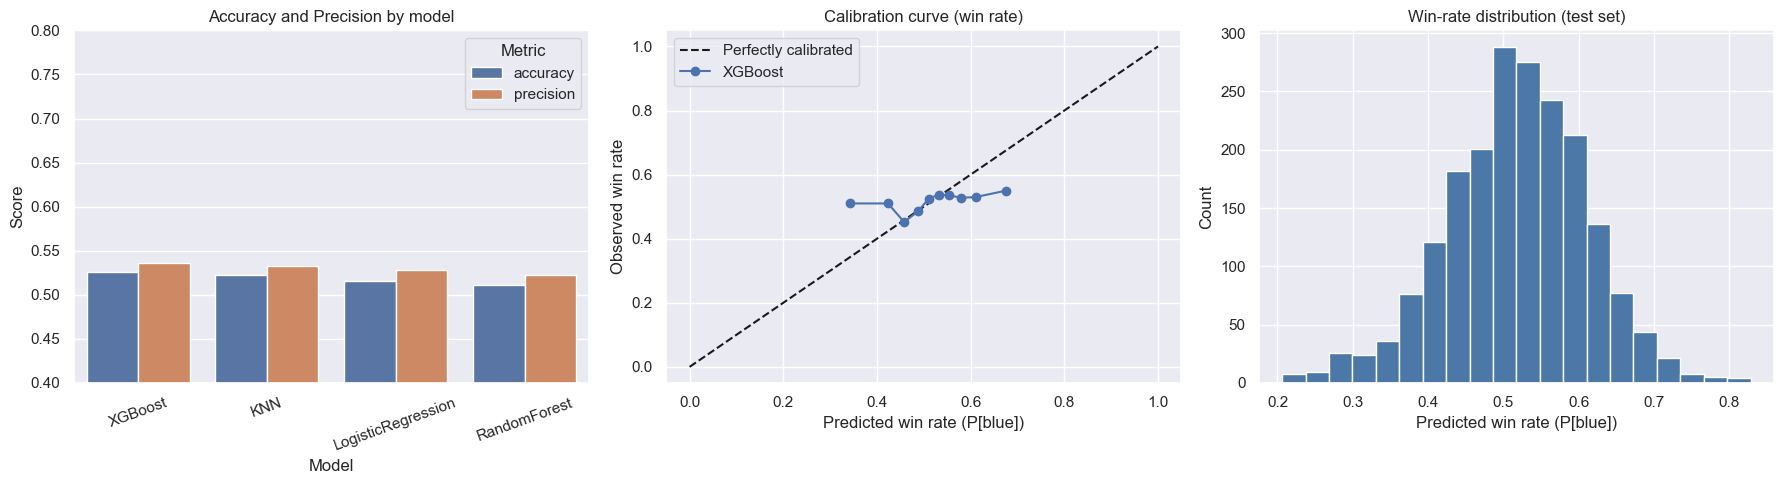

Selected pregame model: XGBoost. Focus metrics -> Accuracy: 0.526, Precision: 0.536. We report win rates (probabilities), not win/lose statements.


In [138]:
# Pregame draft-only ML comparison
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, log_loss, brier_score_loss
from collections import OrderedDict
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

# Load pregame table
pg_cols = ['matchId','bluetop','bluejg','bluemid','bluebot','bluesupport',
           'redtop','redjg','redmid','redbot','redsupport']
pg_df = pd.read_parquet(PREGAME_FULL)[pg_cols]

# Robust label loader (avoid dependency on specific prior cells)
label_col = globals().get('LABEL_COL', 'blue_win')
id_like = list(globals().get('ID_LIKE', {'matchId','match_id','gameId','game_id'}))
def _try_from_df(df):
    if df is None:
        return None
    cols = set(df.columns)
    id_col = next((c for c in id_like if c in cols), None)
    if id_col is None:
        return None
    lbl = label_col if label_col in cols else ('blue_win' if 'blue_win' in cols else None)
    if lbl is None:
        return None
    out = df[[id_col, lbl]].rename(columns={id_col:'matchId', lbl:'blue_win'})
    return out
def load_labels():
    # 1) Try in-memory full_df
    lbls = None
    try:
        lbls = _try_from_df(globals().get('full_df'))
    except Exception:
        lbls = None
    if lbls is not None:
        return lbls.dropna()
    # 2) Try known file paths in order of preference
    for path_var in ['FIFTEEN_PARQUET','LABELS_FULL','lbl_parquet','FIFTEEN_PREVIEW','LABELS_PREVIEW','lbl_preview']:
        p = globals().get(path_var)
        if p is None:
            continue
        try:
            p_str = str(p)
            df_ = pd.read_parquet(p_str) if p_str.endswith('.parquet') else pd.read_csv(p_str)
            lbls = _try_from_df(df_)
            if lbls is not None:
                return lbls.dropna()
        except Exception:
            continue
    raise RuntimeError('Could not locate labels with matchId and blue_win.')

labels_df = load_labels()
df_pg = pg_df.merge(labels_df, on='matchId', how='inner').dropna()

# One-hot encode champions per role (categorical dummies). Keep clear prefixes.
cat_cols = ['bluetop','bluejg','bluemid','bluebot','bluesupport','redtop','redjg','redmid','redbot','redsupport']
X = pd.get_dummies(df_pg[cat_cols], prefix=cat_cols, dtype=np.uint8)
y = df_pg['blue_win'].astype(int)

# Train/test split (keep same RANDOM_STATE for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Define models to compare
models = OrderedDict()
models['LogisticRegression'] = LogisticRegression(max_iter=1000, n_jobs=None)
models['RandomForest'] = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
models['KNN'] = KNeighborsClassifier(n_neighbors=25, weights='distance')
if _HAS_XGB:
    models['XGBoost'] = XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, random_state=RANDOM_STATE,
        eval_metric='logloss', tree_method='hist'
)

results = []
probas = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    if hasattr(clf, 'predict_proba'):
        p_test = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, 'decision_function'):
        # Map decision scores to 0..1 via logistic for comparability
        scores = clf.decision_function(X_test)
        p_test = 1 / (1 + np.exp(-scores))
    else:
        # Fallback: use predictions as probabilities (degrades metrics using probas)
        p_test = clf.predict(X_test).astype(float)
    probas[name] = p_test

    y_pred = (p_test >= 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, p_test)
    ll = log_loss(y_test, p_test, labels=[0,1])
    br = brier_score_loss(y_test, p_test)
    results.append({'model': name, 'accuracy': acc, 'precision': prec, 'roc_auc': auc, 'log_loss': ll, 'brier': br})

results_df = pd.DataFrame(results).sort_values(['accuracy','precision','roc_auc'], ascending=[False, False, False]).reset_index(drop=True)
display(results_df)

# Pick best model by accuracy then precision
best_name = results_df.loc[0, 'model']
print({
    'best_model': best_name,
    'accuracy': float(results_df.loc[0, 'accuracy']),
    'precision': float(results_df.loc[0, 'precision']),
    'roc_auc': float(results_df.loc[0, 'roc_auc']),
    'log_loss': float(results_df.loc[0, 'log_loss']),
    'brier': float(results_df.loc[0, 'brier'])
})

# Visualizations: bar chart for accuracy/precision per model, and a calibration curve for best model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Accuracy & Precision bars
bar_df = results_df.melt(id_vars='model', value_vars=['accuracy','precision'], var_name='metric', value_name='score')
sns.barplot(data=bar_df, x='model', y='score', hue='metric', ax=axes[0])
axes[0].set_ylim(0.4, 0.8)
axes[0].set_title('Accuracy and Precision by model')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(title='Metric')
for label in axes[0].get_xticklabels():
    label.set_rotation(20)

# 2) Calibration (reliability) curve for best model (win-rate focus)
from sklearn.calibration import calibration_curve
p_best = probas[best_name]
frac_pos, mean_pred = calibration_curve(y_test, p_best, n_bins=10, strategy='quantile')
axes[1].plot([0,1],[0,1], 'k--', label='Perfectly calibrated')
axes[1].plot(mean_pred, frac_pos, marker='o', label=f'{best_name}')
axes[1].set_xlabel('Predicted win rate (P[blue])')
axes[1].set_ylabel('Observed win rate')
axes[1].set_title('Calibration curve (win rate)')
axes[1].legend()

# 3) Distribution of predicted win rates (best model)
axes[2].hist(p_best, bins=20, color='#4c78a8', edgecolor='white')
axes[2].set_xlabel('Predicted win rate (P[blue])')
axes[2].set_ylabel('Count')
axes[2].set_title('Win-rate distribution (test set)')

plt.tight_layout()
plt.show()

# Fit final model on the train split to be explicit (already fitted), expose for later use
final_model_pregame = models[best_name]
final_model_name_pregame = best_name

# Small summary line focusing on win rate
print(f"Selected pregame model: {best_name}. Focus metrics -> Accuracy: {results_df.loc[0, 'accuracy']:.3f}, Precision: {results_df.loc[0, 'precision']:.3f}. We report win rates (probabilities), not win/lose statements.")